Applied Competitive Lab in Data Science Project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np

In [2]:
# !git clone https://github.com/shkitan/ds_project.git

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd drive/MyDrive/ds_final_project

/content/drive/MyDrive/ds_final_project


In [5]:
df = pd.read_csv('data.csv', index_col=0)

In [6]:
target_classes = df['STAT_CAUSE_DESCR'].unique()
target_classes

array(['Miscellaneous', 'Arson', 'Debris Burning', 'Smoking', 'Campfire',
       'Equipment Use', 'Powerline', 'Lightning', 'Railroad', 'Children',
       'Fireworks', 'Structure'], dtype=object)

In [7]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(df['STAT_CAUSE_DESCR'])

LabelEncoder()

In [8]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Geo Spacial data

## EDA

We can notice that some states have a high amount of incidents where most states have less than or equal to 10k. A big amount of the Debris Burnings happened in Georgia and Texas, states that are characterized with dry and hot climate.


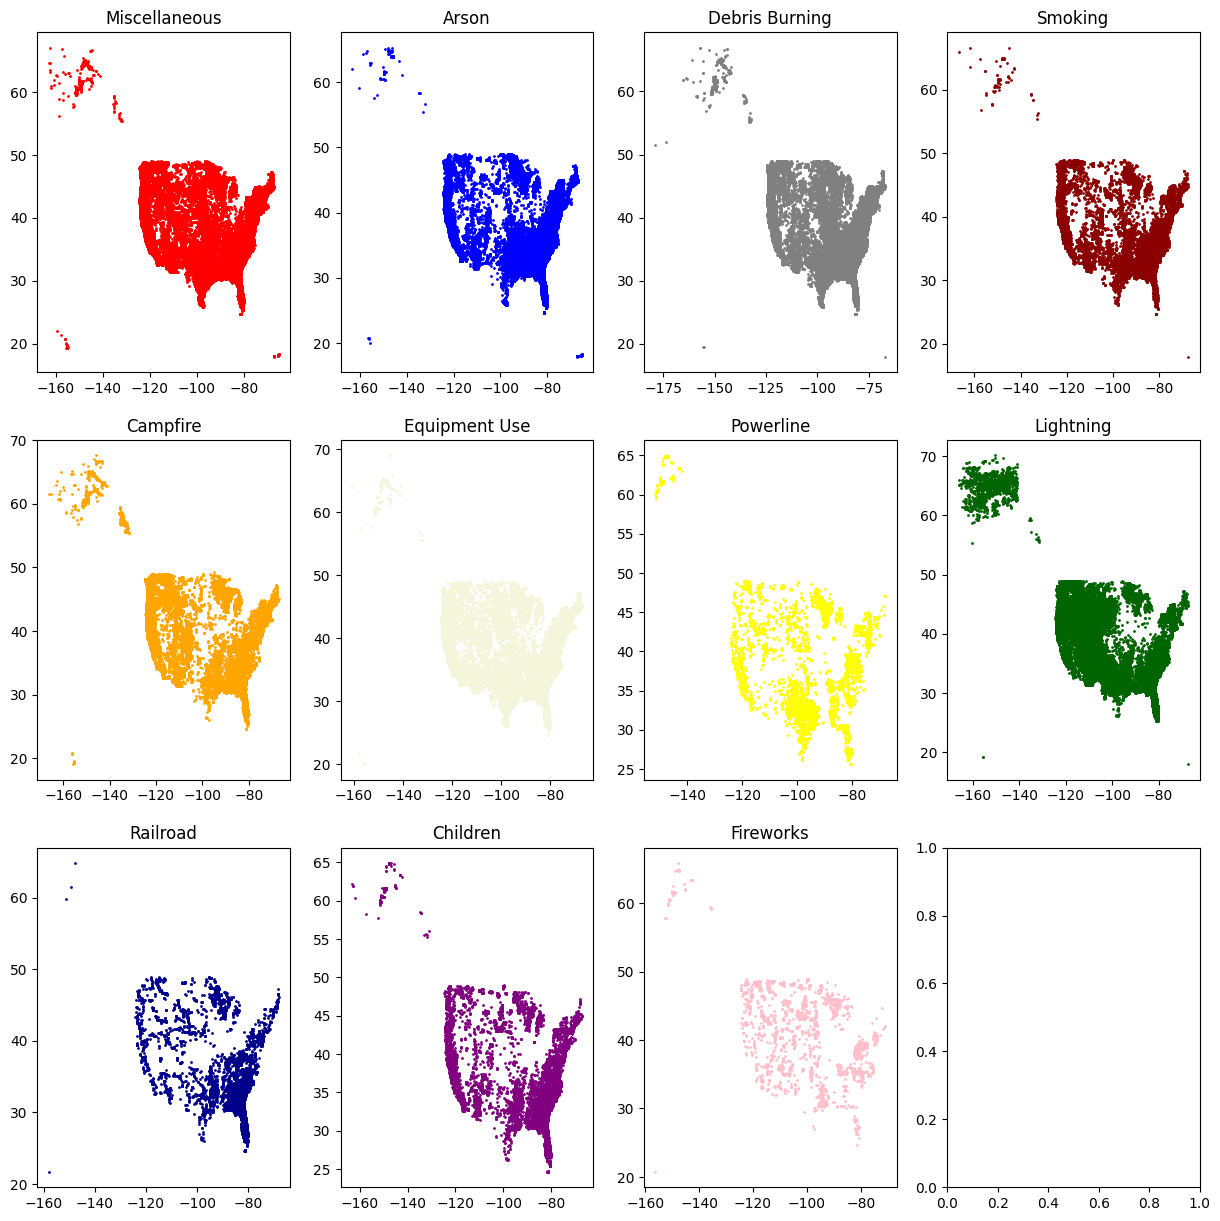

In [9]:
# We give color for each cause to see each cause on a map
colors = ['red', 'blue','gray','darkred','orange', 'beige','yellow', 'darkgreen','darkblue','purple','pink', 'lightgray','green', 'black']
causes = df['STAT_CAUSE_DESCR'].unique()[:-1]
colors_cause_dic = {causes[i]: colors[i] for i in range(len(causes))}
fig, ax = plt.subplots(3, 4, figsize=(15, 15))
for i, cause in enumerate(colors_cause_dic.keys()):
  row = i//4
  col = i%4
  ax[row, col].scatter(x=df[df['STAT_CAUSE_DESCR'] == cause]['LONGITUDE'],
             y=df[df['STAT_CAUSE_DESCR'] == cause]['LATITUDE'],
             c=colors_cause_dic[cause], label=cause, s=1)
  ax[row, col].set_title(cause)
plt.show()

Indeed we can see that the Debris Burning is dense at the South and East side of the map where Texas and Georgia are. We can also look at lightning and see a big dense circle at the top left where Alaska is.


We checked the distribution of the labels per state to see if we can detect some anomaly cases

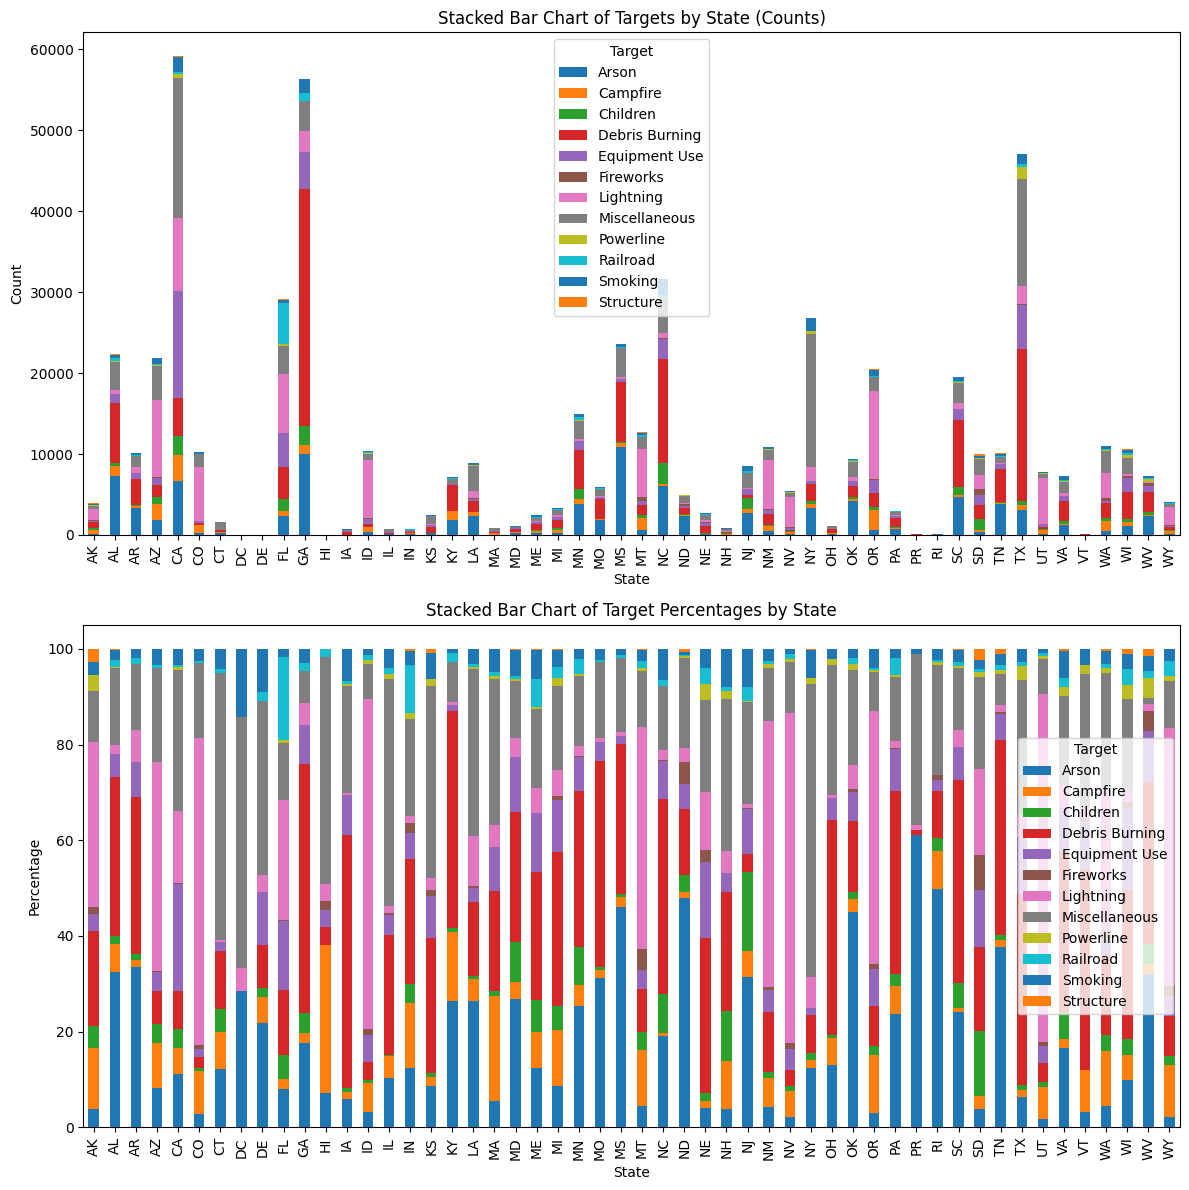

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'state' and 'target', then counting occurrences
grouped = df.groupby(['STATE', 'STAT_CAUSE_DESCR']).size().unstack(fill_value=0)

# Calculating percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting stacked bar charts
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plotting counts
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Stacked Bar Chart of Targets by State (Counts)')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')
axes[0].legend(title='Target')
axes[0].tick_params(axis='x', rotation=90)

# Plotting percentages
grouped_percentage.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Stacked Bar Chart of Target Percentages by State')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Target')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

We fix a state, and see how the distribution will change. We use the new distribution to divide by the original distribution to understand how much the fixing of the state influences the prediction of the target classes.


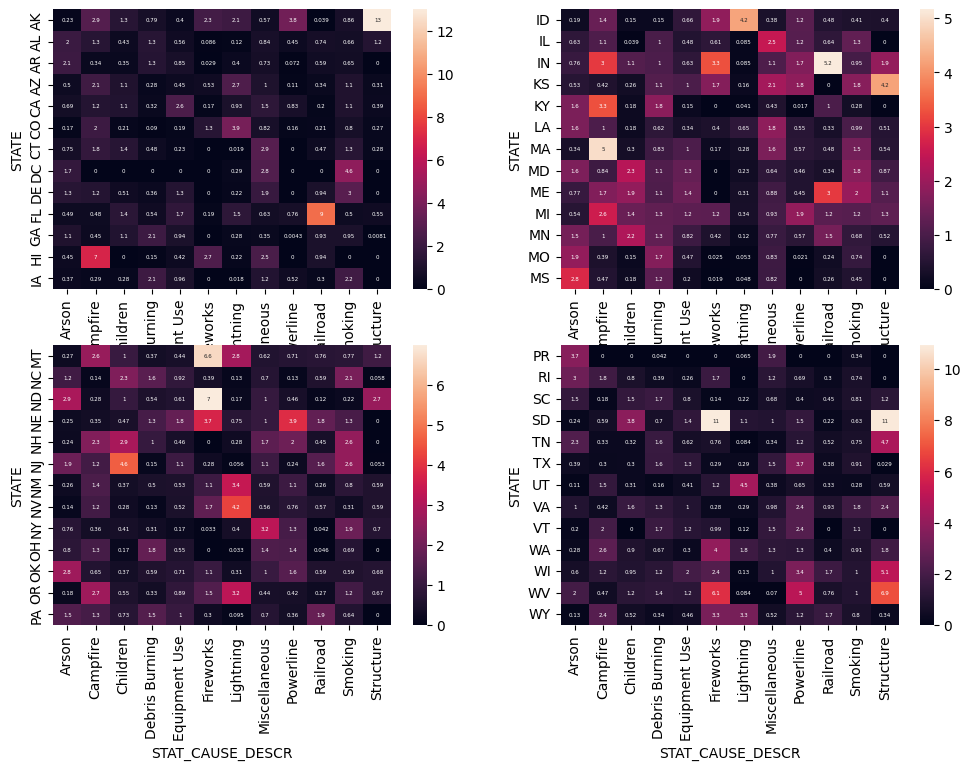

In [11]:
percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
def plot_big_crosstab_vs_original(df, feature_name, n_rows, n_cols):
  # no need input check here: n_rows/cols of the plot, not of dataframe
  total_plots = n_rows * n_cols
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
  cross_Vals = pd.crosstab(df[feature_name], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  axes = axes.flatten()

  for i in range(total_plots):
    start_idx = i * len(cross_Vals) // total_plots
    end_idx = (i + 1) * len(cross_Vals) // total_plots
    subset_df = cross_Vals.iloc[start_idx: end_idx]
    sns.heatmap(subset_df, annot=True, annot_kws={"fontsize":4}, ax=axes[i])
  plt.show()
plot_big_crosstab_vs_original(df, 'STATE', 2, 2)

## Feature Engineering

### Longitude and latitude

First thing we do, is simply passing in the longitude and latitude to the model, and this increase the result by 0.5 percent.



Now we will cluster the points using DBSCAN, and then calculate the distance of each point to it's nearest cluster. (Distance to centroid of the cluster).  We will do this also group by each target class in the target

In [12]:
from sklearn.cluster import DBSCAN

target_class_clusters = {}
def get_clusters_centroids(df):
  epsilon = 0.5  # maximum distance between points to be considered in the same neighborhood
  min_samples = 5  # minimum number of points in a neighborhood to be considered a core point
  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  # now apply DBSCAN
  dbscan.fit(df[['LATITUDE', 'LONGITUDE']])
  # Get the indices of core samples
  core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
  core_samples_mask[dbscan.core_sample_indices_] = True
  # Get the unique cluster labels
  labels = dbscan.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  # Now Calculate the cluster centroids
  clusters_centroids = []
  for i in range(n_clusters):
      cluster_points = df[['LATITUDE', 'LONGITUDE']][labels == i]
      cluster_center = np.mean(cluster_points, axis=0)
      clusters_centroids.append(cluster_center)
  clusters_centroids = np.array(clusters_centroids)
  return clusters_centroids

def train_target_class_clusters(df):
  for target_class in target_classes:
    df_target_class = df[df['STAT_CAUSE_DESCR']== target_class]
    target_class_clusters[target_class] = get_clusters_centroids(df_target_class)


In [13]:
def encode_dis_to_nearest_centroid(row, target_class):
  clusters_centroids = target_class_clusters[target_class]
  point = [row['LATITUDE'], row['LONGITUDE']]
  cluster_distances = np.linalg.norm(clusters_centroids - point, axis=1)  # Calculate distances to all centroids at once
  min_distance = np.min(cluster_distances)  # Find the minimum distance
  return min_distance



### STATE

We encode the state by how much they contribute to predicting the target class. Basically we take the number in the heatmap above, and for each target class, we encode the sample by how much the state this sample is in affects the prediction of the label.



In [14]:
state_significance = {}

def train_state_encoders(df):
  # find out for each class which states will have higher than normal percentage of the class instance.
  percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
  cross_Vals = pd.crosstab(df['STATE'], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)

  # For each class, we will encode each state to "how important they are to prediction the class"
  for target_class in target_classes:
    state_significance_per_class = {}
    for state in cross_Vals.index:
      significance = cross_Vals.loc[state, target_class]
      state_significance_per_class[state] = significance
    state_significance[target_class] = state_significance_per_class




Notice here that we could have train one column, comparing whole distribution using kl divergence, but I split it up for each class, hoping that this might provide more insight. Turns out this is a very important approach. All the features generated here are the most important features.

### COUNTY

There are some missing values in county. And we can see that county-fip_code-fip_name are being null together.   
Also we can see that county being null have a negative influence on powerline and rail road.  
So since XGBoost can fill in null values, we passed this feature in as is, and it helped the performance.


In [15]:
def encode_geospacial_data(df):
  # encode state
  for target_class in target_classes:
    df['SE-'+ target_class] = df['STATE'].map(state_significance[target_class])

  # encode longitude and latitude
  for target_class in target_classes:
    df['DISTANCE_TO_CLUSTERS-'+target_class] = df.apply(encode_dis_to_nearest_centroid,args=(target_class,), axis=1)
  return df

In [16]:
state_encoding_features = ['SE-' + target_class for target_class in target_classes]
coordinate_encoding_features = ['DISTANCE_TO_CLUSTERS-'+target_class for target_class in target_classes]
geospacial_features = state_encoding_features + ['LATITUDE', 'LONGITUDE'] + coordinate_encoding_features

# Time data

## EDA

We need to make some alternation on the data first in order to show pictures

In [17]:
# save the original df, we will trasform df back later
original_df = df.copy()

In [18]:
# simple reformatting
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')

# encode month and day of week (weekend or not.) Here we do not use numerical values becasue it might be non ordinal
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
# notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

# I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

# Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
# And I will both one hot encode it and frequency encode it
df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                        5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                        9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
# For null time data: Discovery time, control date, control time etc.
# encode discovery time
df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

# encode delta time
df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                          format='%Y-%m-%d %H:%M:%S', errors='coerce')


df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                          format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the time difference
df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()


Let's see how a fire year affects the distribution of the target labels. We first calculate the distribution of the target classes when fixed a year then we use the distribution divided by the original distribution of the target classes.

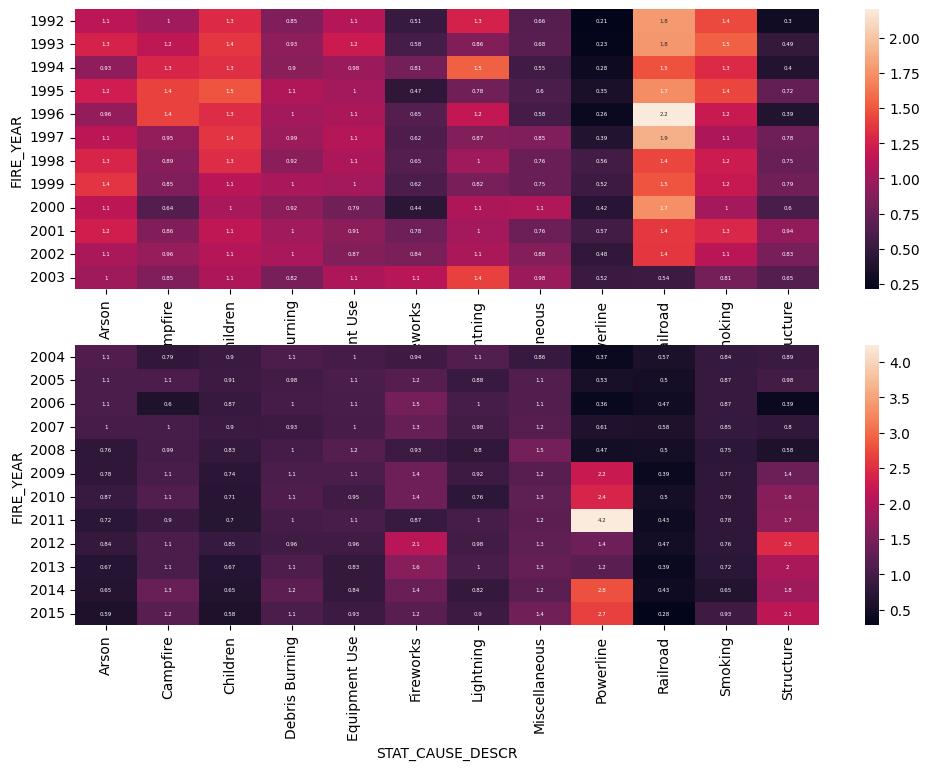

In [19]:
plot_big_crosstab_vs_original(df, 'FIRE_YEAR', 2, 1)

We can see that some target classes such as Arson and Railroad have higher percentage in the distribution in earlier years, and some other target classes, such as Powerline, have higher percentage in the distribution in recent years. This seems to be reasonable.

Now we explore how the day of week and month would affect the number of fires.


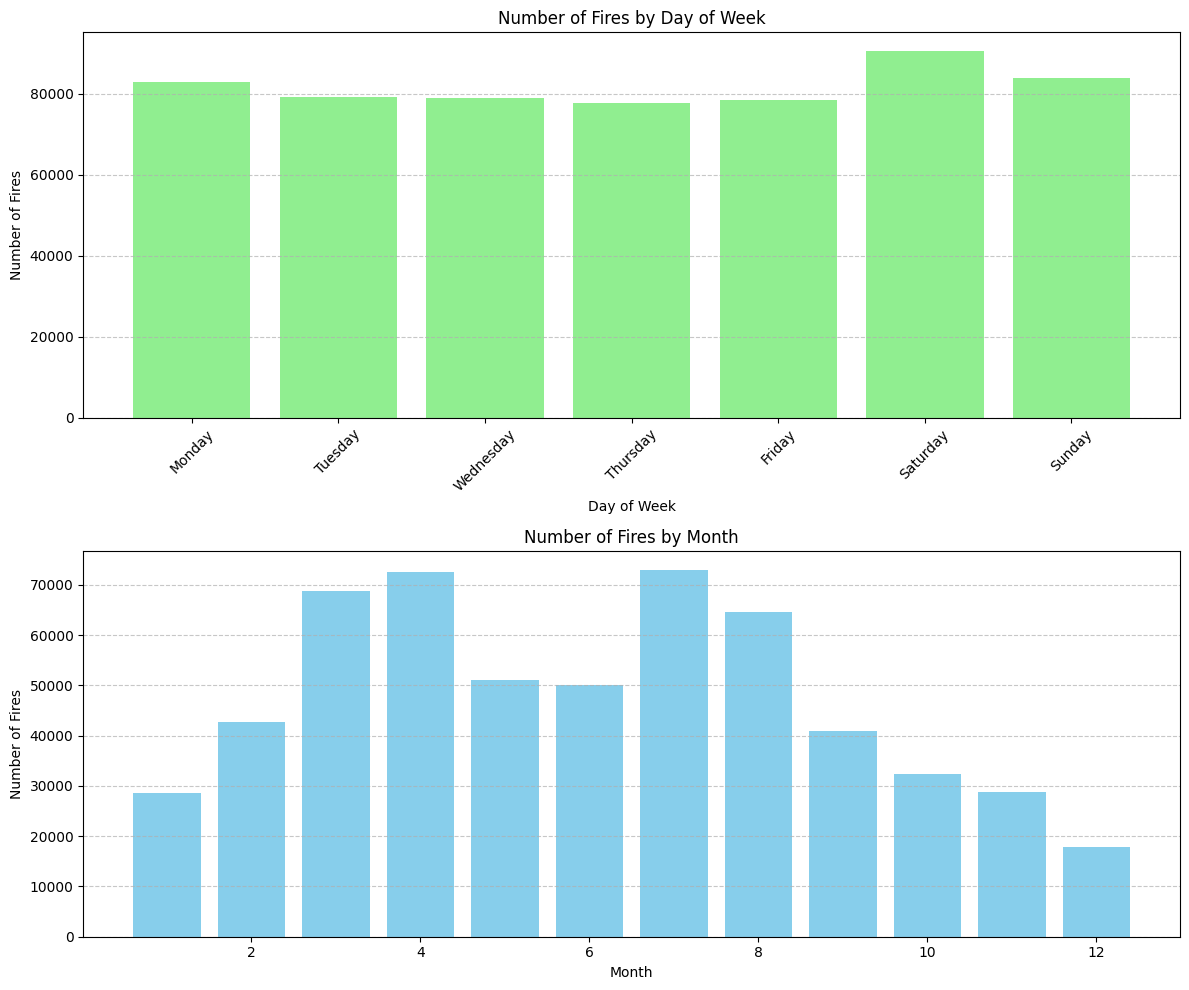

In [20]:
# Plotting the graph
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))



df['day_of_week'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.dayofweek
day_of_week_counts = df.groupby('day_of_week').size()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

axes[0].bar(range(7), day_of_week_counts, color='lightgreen')
axes[0].set_title('Number of Fires by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Fires')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

df['month'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.month
monthly_counts = df.groupby('month').size()
axes[1].bar(monthly_counts.index, monthly_counts, color='skyblue')
axes[1].set_title('Number of Fires by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Fires')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


We can see that on Saturdays and Sundays, the number of fires are slightly higher. And in March and April, and also in July and august.

We plot out for each target class, how the number fluctuate in the year and in the week.


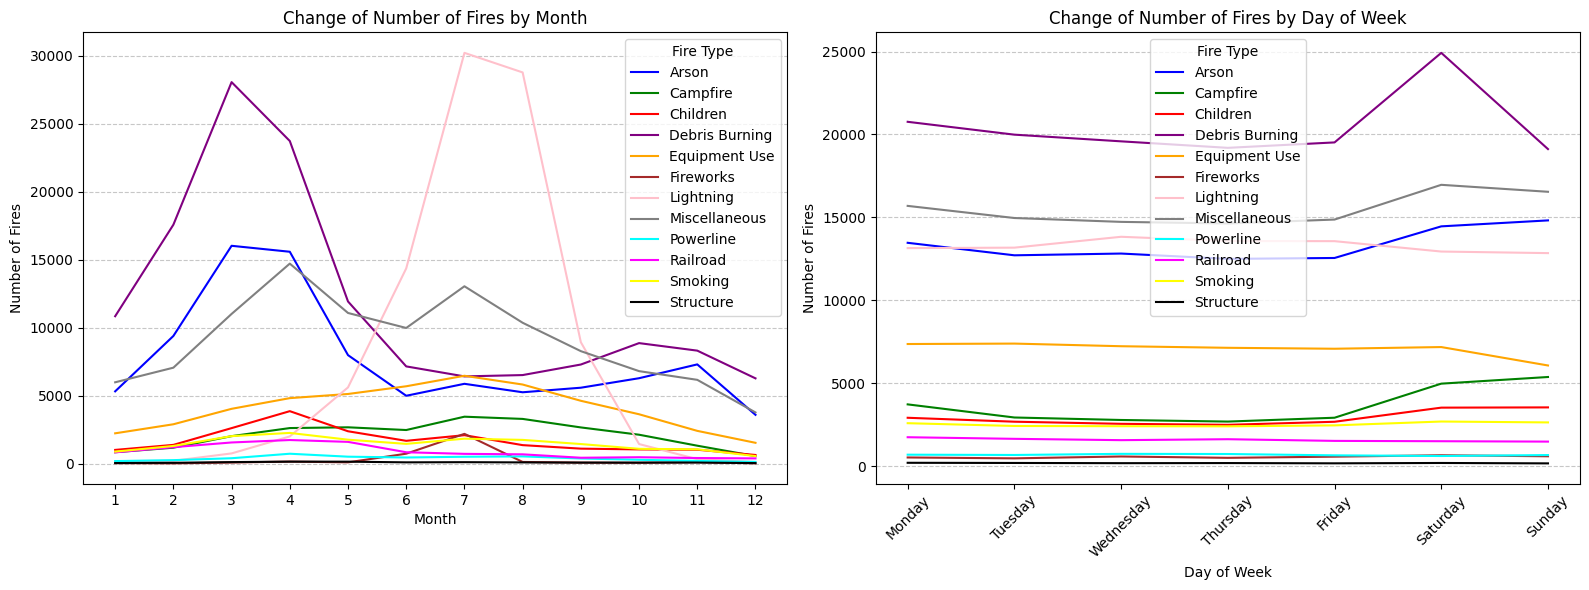

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'black']

grouped_monthly = df.groupby(['STAT_CAUSE_DESCR', 'month']).size().unstack(fill_value=0)
for i, fire_type in enumerate(grouped_monthly.index):
    axes[0].plot(grouped_monthly.columns, grouped_monthly.loc[fire_type], label=fire_type, color=colors[i])

axes[0].set_title('Change of Number of Fires by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Fires')
axes[0].set_xticks(range(1, 13))
axes[0].legend(title='Fire Type')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

grouped_daily = df.groupby(['STAT_CAUSE_DESCR', 'day_of_week']).size().unstack(fill_value=0)
for i, fire_type in enumerate(grouped_daily.index):
    axes[1].plot(grouped_daily.columns, grouped_daily.loc[fire_type], label=fire_type, color=colors[i])

axes[1].set_title('Change of Number of Fires by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Fires')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
axes[1].legend(title='Fire Type')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Then just like above, we will see how fixing a month and fixing a day of time would affect the distribution of the target classes.

In [22]:
def plot_crosstab_heatmap_vs_original(df, feature_name, axes=None):
  cross_Vals = pd.crosstab(df[feature_name], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  if axes is None:
    sns.heatmap(cross_Vals, annot=True, annot_kws={"fontsize":4})
  else:
    sns.heatmap(cross_Vals, annot=True, annot_kws={"fontsize":4}, ax=axes)


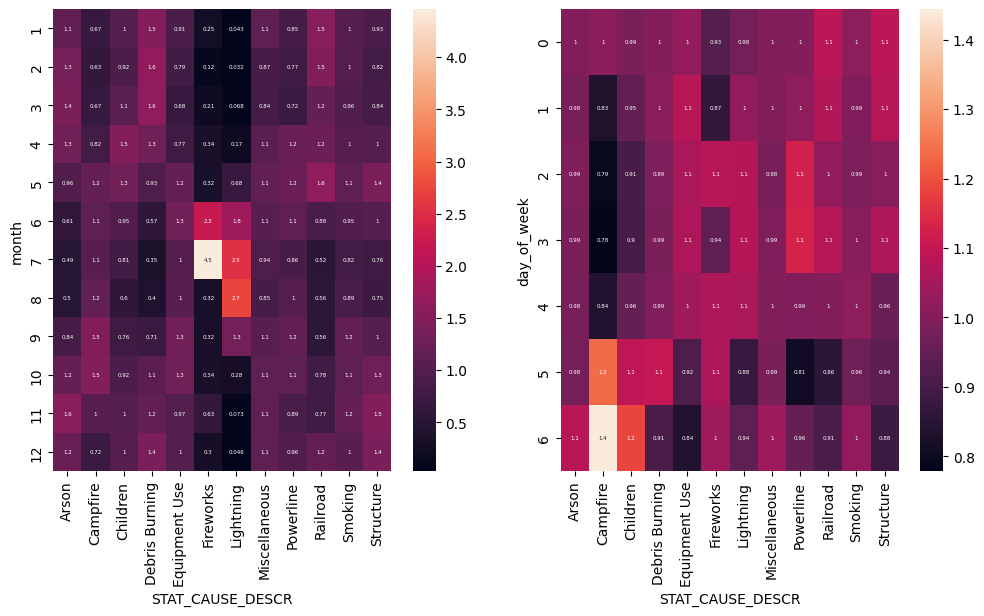

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot_crosstab_heatmap_vs_original(df, 'month', axes[0])
plot_crosstab_heatmap_vs_original(df, 'day_of_week', axes[1])
plt.show()

We can see that Fireworks are abnormally high in July, and Campfires are very high on Saturday and Sunday. Both make sense. So in order to further verify our hypothesis, let’s look at firework’s number during july.

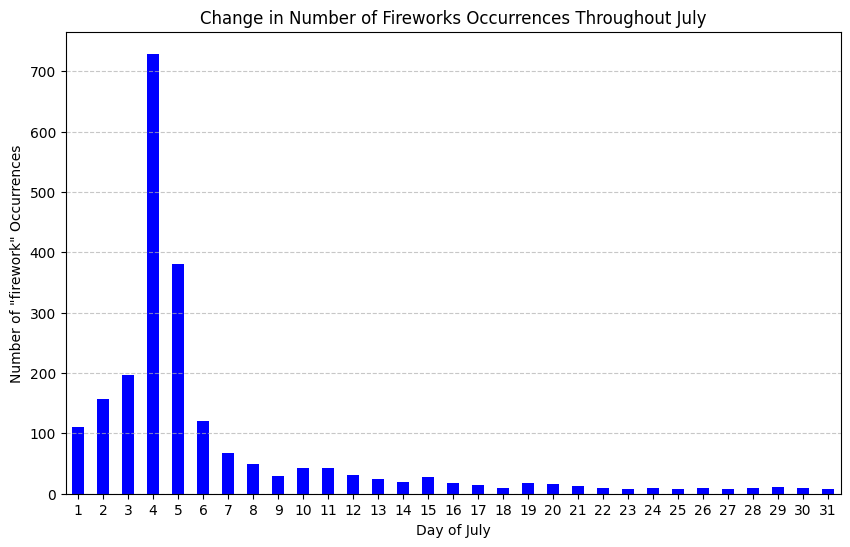

In [24]:
# Filter the data for the month of July
july_data = df[df['DISCOVERY_DATE'].dt.month == 7]

# Filter the data for rows where the 'cause' column is 'firework'
firework_data = july_data[july_data['STAT_CAUSE_DESCR'] == 'Fireworks']

# Group by date and count the occurrences of 'firework'
firework_counts = firework_data.groupby(firework_data['DISCOVERY_DATE'].dt.day).size()
# Plot the change in the number of 'firework' occurrences throughout July
plt.figure(figsize=(10, 6))
firework_counts.plot(kind='bar', color='blue')
plt.xlabel('Day of July')
plt.ylabel('Number of "firework" Occurrences')
plt.title('Change in Number of Fireworks Occurrences Throughout July')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

We can see that the firework number increment is indeed because of July the 4th.


Also we want to look at how does each target class fluctuates during the year every day, so we plotted:

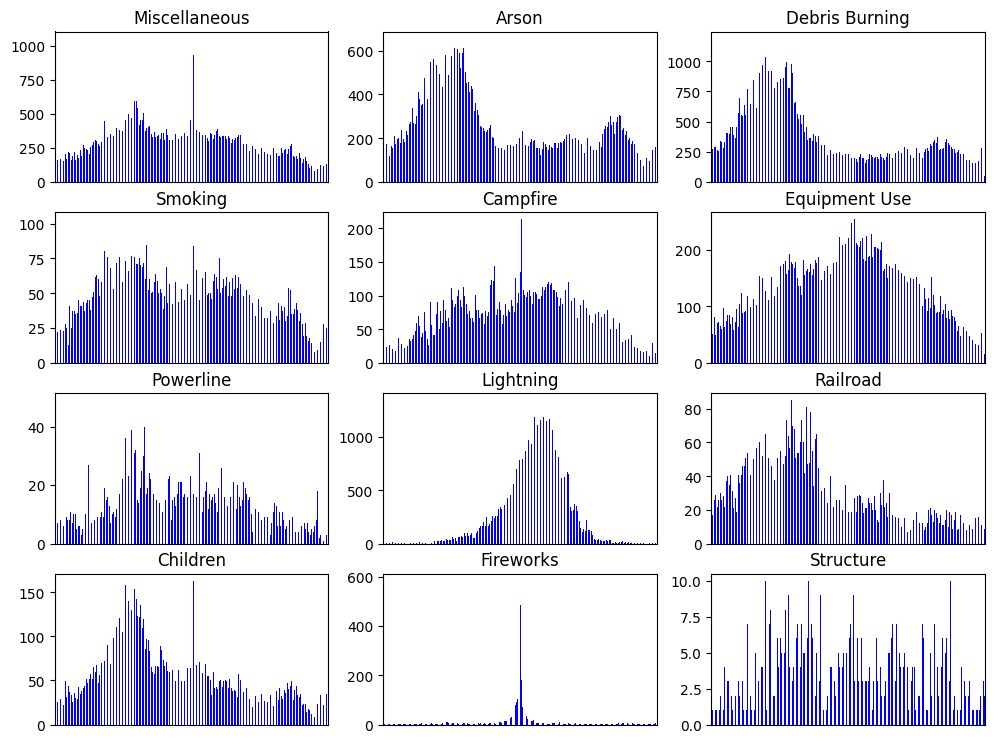

In [25]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(4, 3, figsize=(12, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
  target_class_df = df[df['STAT_CAUSE_DESCR'] == target_class]
  target_class_counts = target_class_df.groupby(df['DISCOVERY_DOY']).size()
  target_class_counts.plot(kind='bar', color='blue', ax=axes[i])
  axes[i].set_title(target_class)
  axes[i].set_xticks([])
  axes[i].set_xlabel('')


plt.show()

We can see that some target classes are more common in the summers and some are more common in the Spring, this explains why we see that the number of fires are higher in spring and summer. From here we also see that miscellaneous fireworks have overlaps Fireworks on July the fourth, and it also overlaps with many other classes. In order to make better predictions, maybe we should separate this class.

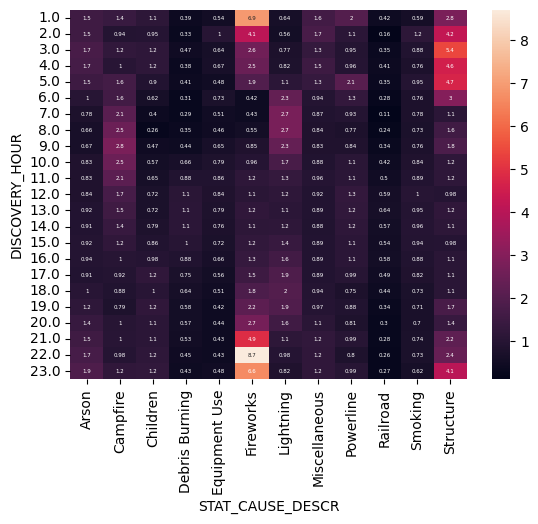

In [26]:
df =  df.dropna(subset=['DISCOVERY_TIME'])
plot_crosstab_heatmap_vs_original(df, 'DISCOVERY_HOUR')

We can see that some columns like Campfire are more likely to happen during day time, and some other columns such as fireworks are more likely to happen during night time, and they all make sense.

Something else we can do: we can see the correlation between two joint features: (feature_1 = a X feature_2 = b). For example, Summer in Alaska.

## Feature Engineering

I will explain what I did in the folllowing function.  
We first convert time to the right format.  
Then from EDA we have seen that season, month and day of week really affects the final prediction. So we will add in this data.  
Then we know that july the fourth is very good indicator for predicting firework, so we will also add this feature.  
The second thing is we can see that Arson, debris buring, railroad and children have more instances in april. While Lighning and equipment use have more instances in July. So I tried to passed them into XGBoost, after a few experiment, we see that it performs better when we use frequency encoding to encode the columns.  
Then we add fire year.    
Then we calculate the time duration. Some of the CONT_DATE is null so we will have to handle it later. In the later chaper I will address this issue.  
Lastly we perform cyclic transformation on several columns, and it doesnot improve nor impair the performance.


In [27]:
import numpy as np

def time_encoding(df):
  # simple reformatting
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
  df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')
  # encode independence day
  df['independence_day'] = (df['DISCOVERY_DATE'].dt.month == 7) & (df['DISCOVERY_DATE'].dt.day.isin([4, 5]))

  # encode month and day of week (weekend or not.)
  df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
  df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
  # notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

  # I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
  df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

  # Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
  # And I will both one hot encode it and frequency encode it
  df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                          5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                          9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
  # For null time data: Discovery time, control date, control time etc.
  # encode discovery time
  df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

  # encode delta time
  df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')


  df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')

  # Calculate the time difference
  df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()

  # Cyclic transformation for DOY, Month, Week, Hour
  df['SIN_DISCOVERY_DOY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/366)
  df['COS_DISCOVERY_DOY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/366)

  df['SIN_MONTH'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)
  df['COS_MONTH'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)

  df['SIN_DAY_OF_WEEK'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)
  df['COS_DAY_OF_WEEK'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)

  df['SIN_HOUR'] = np.sin(2*np.pi*df['DISCOVERY_HOUR']/24)
  df['COS_HOUR'] = np.cos(2*np.pi*df['DISCOVERY_HOUR']/24)

  return df

In [28]:
encoded_time_data = ['independence_day', 'MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'DISCOVERY_HOUR', 'DELTA_TIME',
                     'SIN_DISCOVERY_DOY', 'COS_DISCOVERY_DOY', 'SIN_MONTH', 'COS_MONTH',
                     'SIN_DAY_OF_WEEK', 'COS_DAY_OF_WEEK', 'SIN_HOUR', 'COS_HOUR']

  Result of some experiments: I tried to put the original data along with the frequency encoded data together into the XGBoost, but it lowers the performance.


In order to decide how to handle the null value in DELTA_TIME, let's show the relationship between delta time and FIRE_SIZE and FIRE_SIZE_CLASS

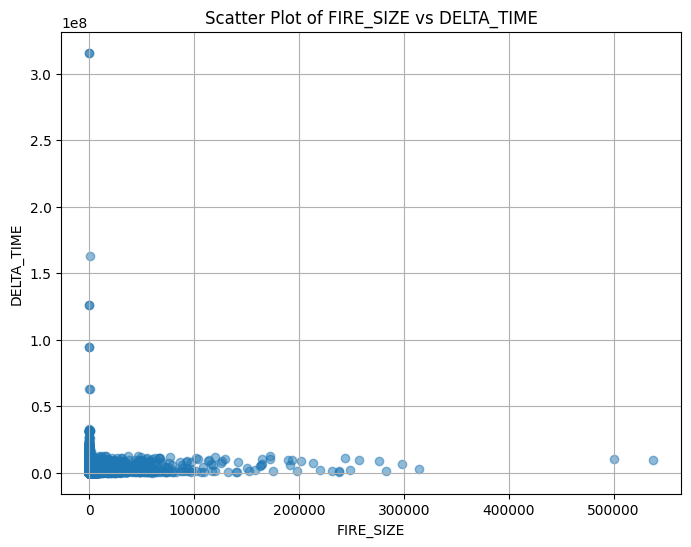

In [29]:
feature1 = 'FIRE_SIZE'
feature2 = 'DELTA_TIME'

plt.figure(figsize=(8, 6))
plt.scatter(df[feature1], df[feature2], alpha=0.5)
plt.title(f'Scatter Plot of {feature1} vs {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.grid(True)
plt.show()

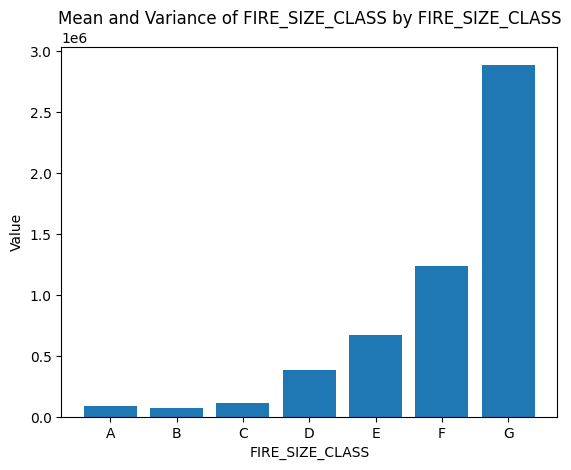

In [30]:
feature3 = 'FIRE_SIZE_CLASS'

grouped_data = df.groupby(feature3)[feature2].agg(['mean']).reset_index()

# Plot bar chart for each category
plt.bar(grouped_data[feature3], grouped_data['mean'])

plt.title(f'Mean and Variance of {feature3} by {feature3}')
plt.xlabel(feature3)
plt.ylabel('Value')
plt.show()

We can see that delta time seems to have correlation with FIRE_SIZE_CLASS, we will adress this in the later chapters.

Remeber to return df to original

In [31]:
df = original_df.copy()

# Catagorical Features

## EDA

First we analyze how each categorical class affects  the target classes, in order to determine if they are worth encoding. For example, the analisis we do for NWCG_REPORTING_AGENCY , OWNER_DESCR, SOURCE_SYSTEM_TYPE, FIRE_SIZE_CLASS


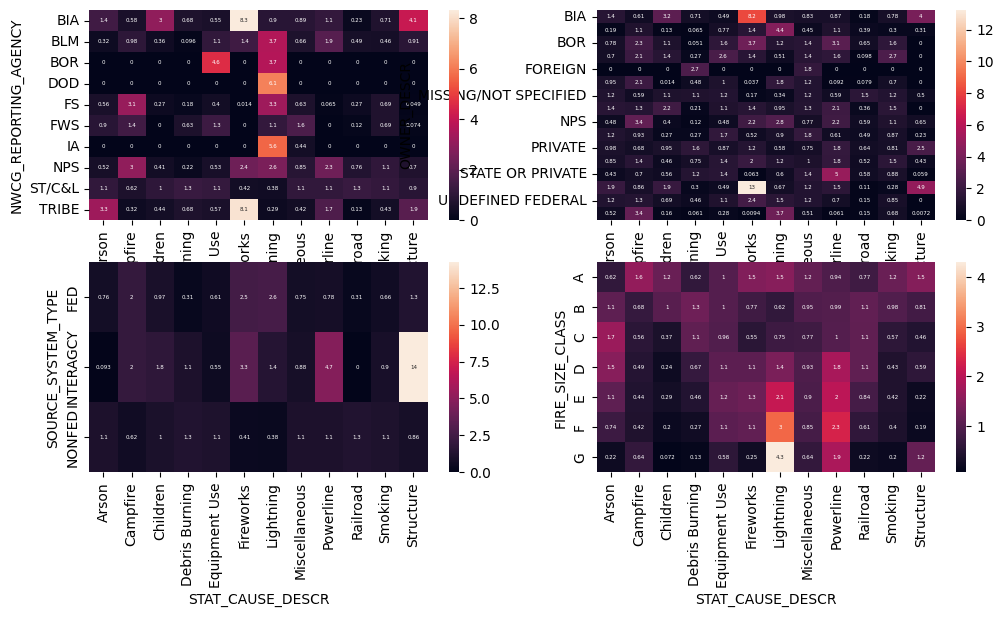

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

plot_crosstab_heatmap_vs_original(df, 'NWCG_REPORTING_AGENCY', axes[0,0])
plot_crosstab_heatmap_vs_original(df, 'OWNER_DESCR', axes[0,1])
plot_crosstab_heatmap_vs_original(df, 'SOURCE_SYSTEM_TYPE', axes[1,0])
plot_crosstab_heatmap_vs_original(df, 'FIRE_SIZE_CLASS', axes[1, 1])
plt.show()

We divided the categorical feature into two groups: HC_features, which encompasses numerous possible value options (High Cardinality), and LC_features, which comprises fewer value options.

## Feature Engineering

### Frequency Encoding

We will train an encoder based on the training set, and then use it to encode both training set and evaluation set.  


In [33]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE',]
catagorical_time_data = ['MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'SEASON', 'DISCOVERY_HOUR']
catagorical_geospacial_data = ['STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']
catagorical_features = HC_features + LC_features + catagorical_time_data + catagorical_geospacial_data

In [34]:
#  generic function for frequency encoding
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder

def frequency_encoding(df):
  for feature in catagorical_features:
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
    # Convert to numeric, coerce errors to NaN, else we cannot fillna(0)
    df['FE-'+ feature] = pd.to_numeric(df['FE-'+ feature], errors='coerce')
    df['FE-'+ feature] = df['FE-'+ feature].fillna(0)
  return df

Result of Experiment: we try to use one hot encoding for low cardinality features and frequency encoding for high cardinality features. However, it turns out that using frequency encoding for every thing performs better. Except for null columns and states. In addition, if we pass both the original feature and the frequency encoded feature to XGBoost, it makes the performance worse.

# Numerical

## EDA

In [35]:
df.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE,FIPS_CODE
count,5.714250e+05,5.714250e+05,571425.000000,5.714250e+05,571425.000000,314476.000000,3.059020e+05,305902.000000,286814.000000,571425.000000,571425.000000,571425.000000,571425.000000,359205.000000
mean,9.266425e+05,5.152594e+07,2003.697939,2.453061e+06,166.302769,1452.604940,2.453324e+06,174.615566,1540.321658,72.818371,37.101224,-95.785956,10.364897,99.875389
std,5.423844e+05,9.880682e+07,6.629826,2.422181e+03,89.574131,405.494339,2.630582e+03,83.517623,432.277391,2261.190807,5.784236,15.928370,4.479953,101.849369
min,1.000000e+00,1.000000e+00,1992.000000,2.448622e+06,1.000000,0.000000,2.448622e+06,1.000000,0.000000,0.000010,17.939722,-178.802600,0.000000,1.000000
25%,4.370660e+05,4.711850e+05,1998.000000,2.451140e+06,92.000000,1239.000000,2.451036e+06,105.000000,1320.000000,0.100000,32.868195,-110.133100,8.000000,29.000000
50%,9.492000e+05,1.076819e+06,2004.000000,2.453104e+06,167.000000,1458.000000,2.453550e+06,183.000000,1600.000000,1.000000,35.605000,-92.254700,14.000000,69.000000
75%,1.388606e+06,1.908442e+07,2009.000000,2.455036e+06,231.000000,1708.000000,2.455764e+06,233.000000,1814.000000,3.000000,41.033200,-82.566000,14.000000,125.000000
max,1.880465e+06,3.003484e+08,2015.000000,2.457388e+06,366.000000,2359.000000,2.457388e+06,366.000000,2359.000000,537627.000000,70.138100,-65.275556,15.000000,810.000000


Let's look at how fire size is distributed among class

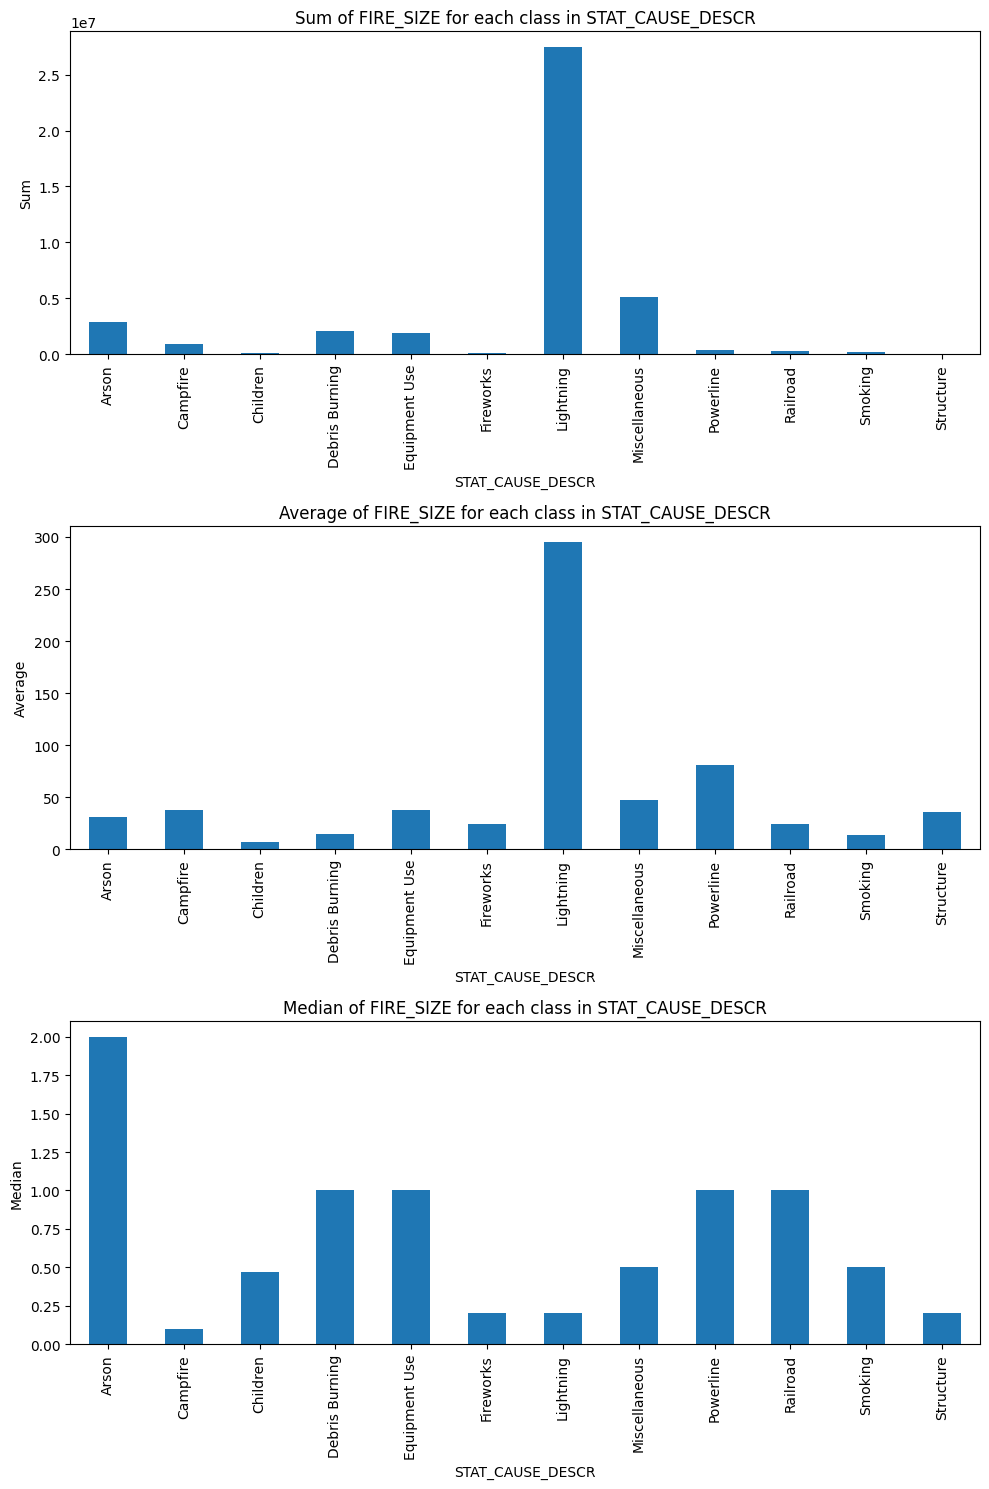

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
# Group by 'feature_1' and calculate sum, average, and median of 'feature_2' within each group
grouped_df = df.groupby('STAT_CAUSE_DESCR')['FIRE_SIZE'].agg(['sum', 'mean', 'median'])

# Create a figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot sum of 'feature_2'
grouped_df['sum'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Sum of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[0].set_ylabel('Sum')

# Plot average of 'feature_2'
grouped_df['mean'].plot(kind='bar', ax=axes[1])
axes[1].set_title('Average of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[1].set_ylabel('Average')

# Plot median of 'feature_2'
grouped_df['median'].plot(kind='bar', ax=axes[2])
axes[2].set_title('Median of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[2].set_ylabel('Median')

plt.tight_layout()
plt.show()

we can see that there is a correlation between the fire size and the target classes. So we can understand that this feature is important for our model.

## Feature Engineering

For FIRE_SIZE, we tried to take the log value of it, however it does not improve or impair the performance, so it's redundent to do so. Another thing is we see that FIRE_SIZE have many outlier points, we will address this issue in the later chapter.

# Additional information

At this experiment we thought  about new features that could correlate to some of the labels in the target and add heuristics for them.
The Experiment involved downloading the NOAA Storm Events Database dataset and preparing it for analysis. The preparation included converting date columns to datetime objects and filtering the dataset to include only records from the years 1992 to 2015, aligning with the timeframe of the wildfire dataset.
To facilitate matching states between the two datasets, a dictionary of state abbreviations was created. This dictionary was then used to replace full state names with their corresponding abbreviations in the storm events dataset.
Subsequently, the focus shifted to the wildfire dataset. I introduced a new column, 'STORM', which served as a boolean indicator to signify whether a wildfire occurred concurrently with a storm in the same state. This determination was made by checking if the combination of the wildfire's discovery date and state matched any entries in the storm events dataset.


In [37]:
df_stormevents = pd.read_csv('storm_events.csv',index_col=0)

In [38]:
# train storm encoder, we will just look at first day of storm
df_stormevents['BEGIN_DATE'] = pd.to_datetime(df_stormevents['BEGIN_DATE'])
storm_by_state = df_stormevents.groupby(['BEGIN_DATE', 'STATE']).groups.keys()

def encode_storm_data(df):
  df['STORM'] = False
  df['STORM'] = df.apply(lambda row: (row['DISCOVERY_DATE'],
                                    row['STATE']) in storm_by_state if row['STATE'] else None, axis=1)
  return df

# Leakage

Leakage are information that we are not suppose to know during prediction. From data set description, we can determin that there are some columns is either leakage or useless. They should contribute to prediction. So we will not use these columns.  


Firstly, OBJECTID, FOD_ID and FPA_ID are irrelavent features, because they are id used to track samples in database. We can see that they are somehow correlated to other features, but we are not suppose to know the id before the sample is stored in the database. So we will consider this a leakage.

<Axes: >

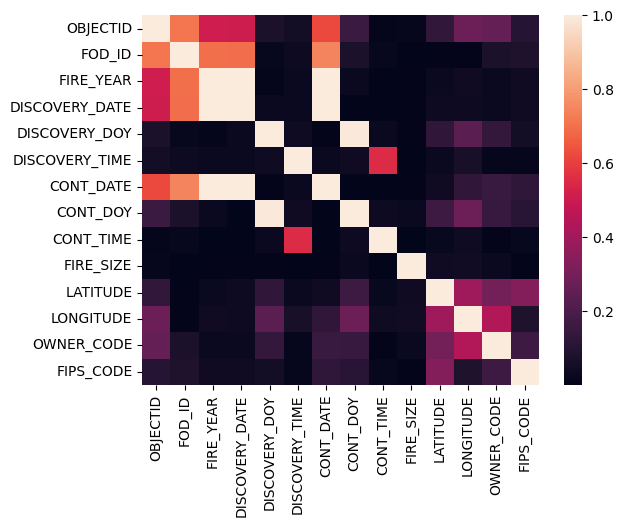

In [39]:
numerical_columns = ['OBJECTID','FOD_ID', 'FIRE_YEAR','DISCOVERY_DATE',
               'DISCOVERY_DOY',	'DISCOVERY_TIME',	'CONT_DATE',	'CONT_DOY',
               'CONT_TIME',	'FIRE_SIZE',	'LATITUDE',	'LONGITUDE','OWNER_CODE','FIPS_CODE']
df_for_correlation = df[numerical_columns]
sns.heatmap(df_for_correlation.corr().abs())

Result of Experiment: there are three ID columns: 'OBJECTID', 'FOD_ID', and 'FPA_ID', which we have observed do not contribute to improving the model. We are concerned that even if they were to help, they could potentially lead to data leakage.


Then we will not use FIRE_NAME and FIRE_CODE since from the description of this two columns, we are not suppose to know the fire name or fire code at the time of prediction.

# Anomaly detection

We will just do a short anomoly detection here. We will look at fire size

In [40]:
import matplotlib.pyplot as plt

def plot_mean_variance_by_category(feature1, feature3, df, rotate_x_lable=False):
    # Group data by categories of feature3 and calculate mean and variance for each group
    grouped_data = df.groupby(feature3)[feature1].agg(['mean', 'std']).reset_index()

    # Plot bar chart for each category
    plt.bar(grouped_data[feature3], grouped_data['mean'], yerr= grouped_data['std'])

    plt.title(f'Mean and Variance of {feature1} by {feature3}')
    if rotate_x_lable == True:
      plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature3)
    plt.ylabel('Value')
    plt.show()

def plot_box_plot(feature1, feature3, df, rotate_x_lable=False):
    df.boxplot(column=feature1, by=feature3)

    plt.title(f'Mean and Variance of {feature1} by {feature3}')
    if rotate_x_lable == True:
      plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature3)
    plt.ylabel('Value')
    plt.show()

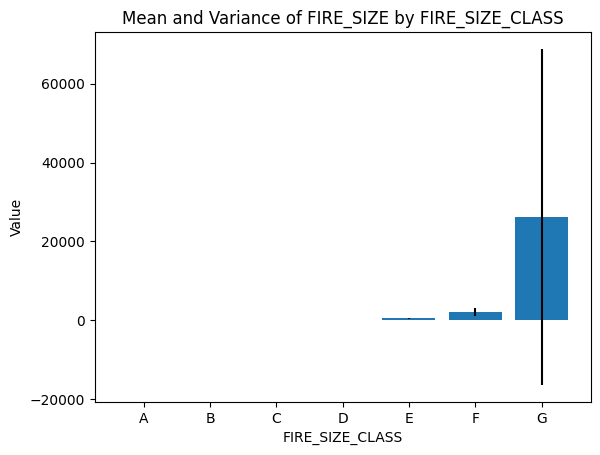

In [41]:
plot_mean_variance_by_category('FIRE_SIZE', 'FIRE_SIZE_CLASS', df)

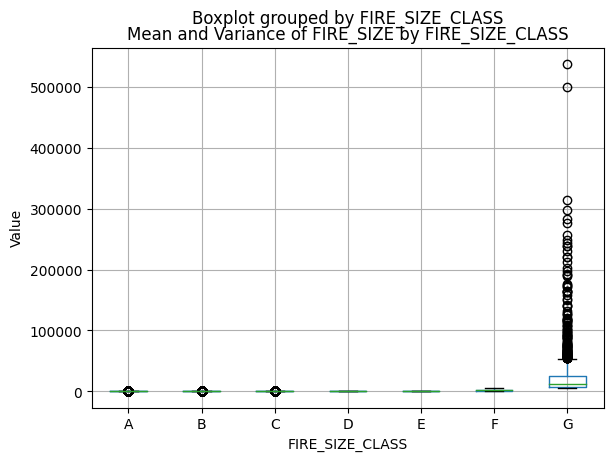

In [42]:
plot_box_plot('FIRE_SIZE', 'FIRE_SIZE_CLASS', df)

We can see that the variance is huge, and there are a lot of fliers. Let's try to get rid of these fliers

In [43]:
def drop_outliers(df):
  non_outlier_list = []
  for fire_size_class in df['FIRE_SIZE_CLASS'].unique():
    df_by_fire_size = df[df['FIRE_SIZE_CLASS']==fire_size_class]
    # Step 1: Calculate Q1 and Q3
    Q1 = df_by_fire_size['FIRE_SIZE'].quantile(0.25)
    Q3 = df_by_fire_size['FIRE_SIZE'].quantile(0.75)

    # Step 2: Calculate IQR
    IQR = Q3 - Q1

    # Step 3: Define threshold for outliers
    threshold = 1.5

    # Step 4: Identify outliers
    non_outlier = df_by_fire_size[(df_by_fire_size['FIRE_SIZE'] >= Q1 - threshold * IQR) & (df_by_fire_size['FIRE_SIZE'] <= Q3 + threshold * IQR)]
    non_outlier_list.append(non_outlier)
  df_non_outlier = pd.concat(non_outlier_list)
  return df_non_outlier

In [44]:
df_non_outlier = drop_outliers(df)

And let's see the fire size afterwards

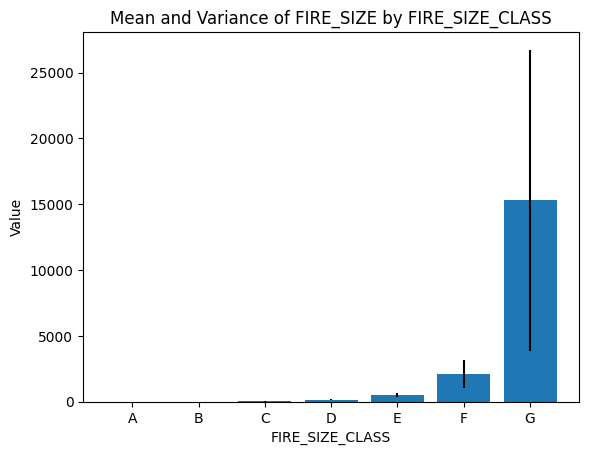

In [45]:
plot_mean_variance_by_category('FIRE_SIZE', 'FIRE_SIZE_CLASS', df_non_outlier)

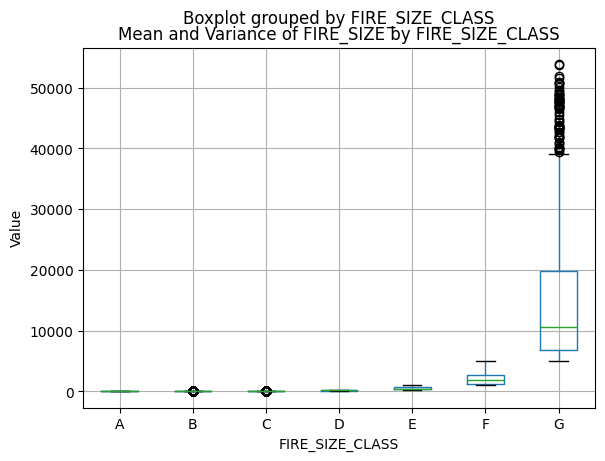

In [46]:
plot_box_plot('FIRE_SIZE', 'FIRE_SIZE_CLASS', df_non_outlier)

Result of Experiment: getting rid of the outliers doesn't really helped, but rather it decreased the accuracy by a little. For more detail see Evaluation XGBoost section.

# Balancing Data

## EDA

We can see that the data is imbalanced

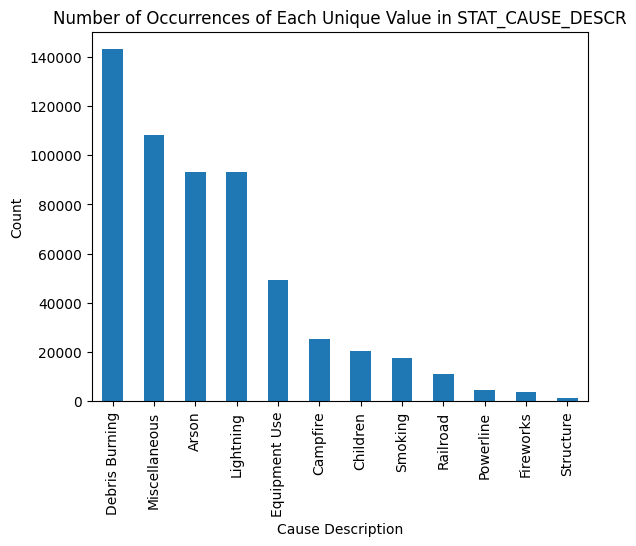

In [47]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar')

# Add labels and title
plt.title('Number of Occurrences of Each Unique Value in STAT_CAUSE_DESCR')
plt.xlabel('Cause Description')
plt.ylabel('Count')

# Show the plot
plt.show()

In [48]:
df['STAT_CAUSE_DESCR'].value_counts()

STAT_CAUSE_DESCR
Debris Burning    143074
Miscellaneous     108372
Arson              93304
Lightning          93057
Equipment Use      49423
Campfire           25367
Children           20354
Smoking            17571
Railroad           11053
Powerline           4733
Fireworks           3865
Structure           1252
Name: count, dtype: int64

We will try to balance the data by passing in the sample weight given by inverse of the target class's porportion.

In [49]:
import numpy as np
def calculate_sample_weights(y_train):
  class_counts = np.bincount(y_train)
  total_example = np.sum(class_counts)
  class_weights = total_example/(len(class_counts)* class_counts)
  sample_weights = class_weights[y_train]
  return sample_weights

Result of Experiment: Balancing doesnot work, because we performed poorly in class "Smoking", but this class is a big class, balancing only assign this class less wight than 1.

# Null columns

## EDA

Let's look at the null columns

In [50]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

,ColumnName,NullNumber,NullPercentage,UniqueValueNumber
0,OBJECTID,0,0.000000,571425
1,FOD_ID,0,0.000000,571425
2,FPA_ID,0,0.000000,571425
3,SOURCE_SYSTEM_TYPE,0,0.000000,3
4,SOURCE_SYSTEM,0,0.000000,32
5,NWCG_REPORTING_AGENCY,0,0.000000,10
6,NWCG_REPORTING_UNIT_ID,0,0.000000,1345
7,NWCG_REPORTING_UNIT_NAME,0,0.000000,1341
8,SOURCE_REPORTING_UNIT,0,0.000000,4124
9,SOURCE_REPORTING_UNIT_NAME,0,0.000000,3611


In [51]:
# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']


Let's see how null columns can affect the distribution of models. The math behind it is just as explained above.

In [52]:
label_distribution_pd_series = []
target_column = 'STAT_CAUSE_DESCR'
for feature_column in null_features:
  # Filter rows where the specified feature is null
  missing_feature_df = df[df[feature_column].isnull()]
  # Get the distribution of target labels for rows where the feature is null
  label_distribution = missing_feature_df[target_column].value_counts(normalize=True)
  label_distribution.name = feature_column
  label_distribution_pd_series.append(label_distribution)
value_count_label_distribution_df = pd.concat(label_distribution_pd_series, axis=1)

label_distribution_pd_series = []
target_column = 'STAT_CAUSE_DESCR'
for feature_column in null_features:
  # Filter rows where the specified feature is null
  missing_feature_df = df[~df[feature_column].isnull()]
  # Get the distribution of target labels for rows where the feature is null
  label_distribution = missing_feature_df[target_column].value_counts(normalize=True)
  label_distribution.name = feature_column
  label_distribution_pd_series.append(label_distribution)
value_count_not_null_label_distribution_df = pd.concat(label_distribution_pd_series, axis=1)

percentage_of_each_label = df[target_column].value_counts(normalize=True)
percentage_of_each_label

diff_value_count_label_distribution_df = value_count_label_distribution_df.div(percentage_of_each_label, axis=0)
diff_value_count_not_null_label_distribution_df = value_count_not_null_label_distribution_df.div(percentage_of_each_label, axis=0)

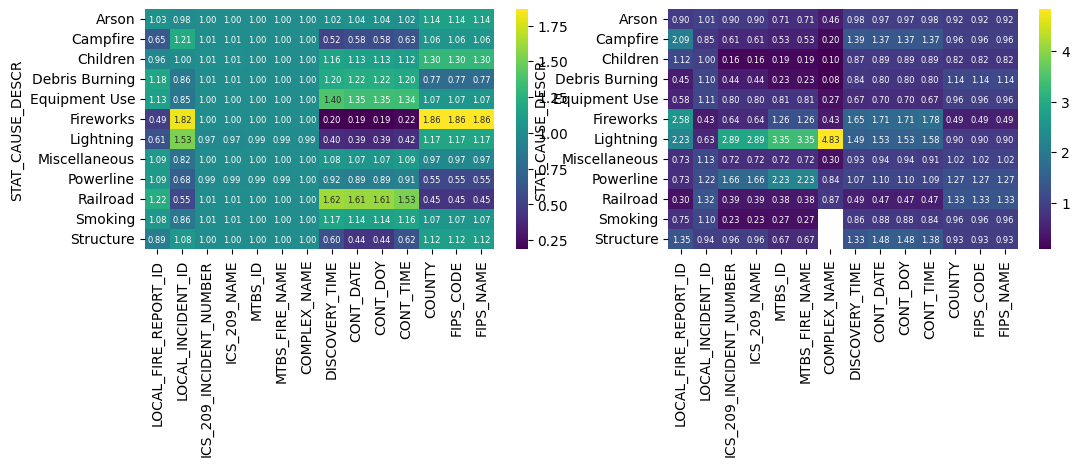

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

# plot two plots
sns.heatmap(diff_value_count_label_distribution_df, annot=True, cmap='viridis', fmt='.2f', annot_kws={"fontsize":6}, ax=ax[0])
sns.heatmap(diff_value_count_not_null_label_distribution_df, annot=True, cmap='viridis', fmt='.2f', annot_kws={"fontsize":6}, ax=ax[1])

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


The left picture is when these columns are null, how much does it affect the distribution of the target classes. The right picture is when the column is not null, how would it affect the distribution.  
We can see that although many features, such as COMPLEX_NAME, have 99% null rate. When it is not null, it provides a great insight on predicting lightning.

Let's see how null features are correlated

<Axes: >

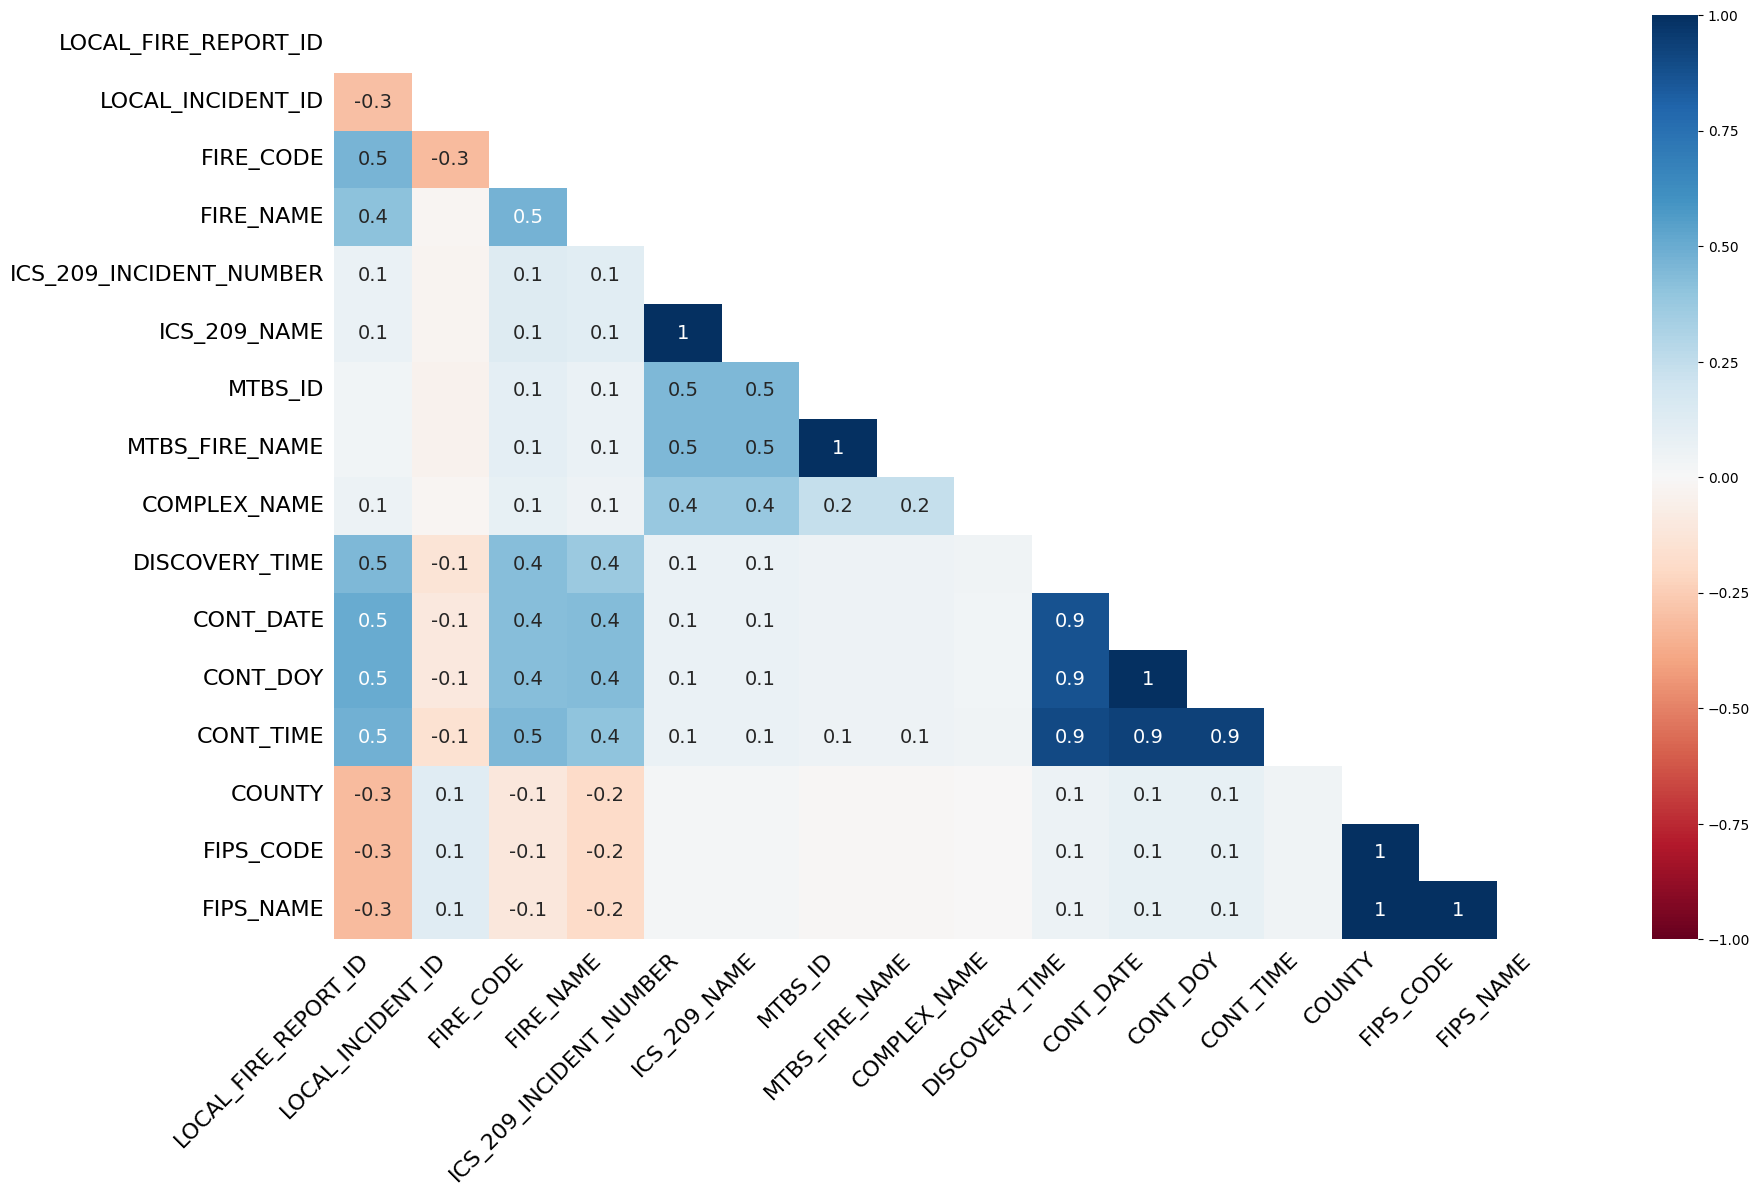

In [54]:
import missingno as msno
msno.heatmap(df)

As we guessed, DISCOVERY_DATE CONT_DATE CONT_DOY CONT_TIME are correlated, COUNTY FIPS_CODE FIPS name are correlated.

## Feature Engineering

### Encoding

There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [55]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Results of Experiments: If we pass in null features as is to XGBoost, it will fill in the null values. Although the training performance becomes really low, the validation error are very high.

### Imputation

There are a few columns that contains null in our training data. We will see if imputation help with accuracy.

We will fill null of county by the state they are in.

In [56]:
def imputate_COUNTY(df):
  df["COUNTY"] = df["COUNTY"].str.lower()
  df.loc[df['COUNTY'].isnull(), 'COUNTY'] = df.loc[df['COUNTY'].isnull(),'STATE']
  return df

Result of Experiment: it doesnot help or impair the performance. So we will keep it, since not every model can fill in null values like XGBoost, it will help with model selection.

As explained in the Time data section, we can see a correlation between DEALTA_TIME and FIRE_SIZE_CLASS. So we will impute DELTA_TIME by the mean of firesize class they are in.

In [57]:
DELTA_TIME_means_by_class_map = {}
def train_DELTA_TIME_IMPUTATOR(df):
  global DELTA_TIME_means_by_class_map
  DELTA_TIME_means_by_class_map = df.groupby('FIRE_SIZE_CLASS')['DELTA_TIME'].agg(['mean'])['mean'].to_dict()

def fill_missing(row):
    if pd.isna(row['DELTA_TIME']):
        return DELTA_TIME_means_by_class_map[row['FIRE_SIZE_CLASS']]
    else:
        return row['DELTA_TIME']
def imputate_DELTA_TIME(df):
  df['DELTA_TIME'] = df.apply(fill_missing, axis=1)
  return df

Result of Experiment: It doesnot help with the over performance, however, when passed in null values without imputation, the training error is lowered while the validation error stays the same.

### Drop Null rows

Instead of dropping features that contains null, we tried to drop null rows, and see how that would afect the performance.

In [58]:
def drop_null_time_rows(X, y):
  df = X
  df['STAT_CAUSE_DESCR'] = y
  df = df.dropna(subset=['DISCOVERY_TIME']).copy()
  y = df['STAT_CAUSE_DESCR']
  X = df.drop(columns=['STAT_CAUSE_DESCR'])
  return X, y

Result of Experiment: It makes the model perform worse.

# Preparation

Now we will prepare the data for XGBoost. In the following function, we basically did all the things we said we have done in the above sections. This takes about 5 mins, since we ran DBSCAN and we have some encodings that takes time to perform.

In [59]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
selected_features = encoded_catagorical_features + encoded_null_features + geospacial_features + ['FIRE_SIZE']+ encoded_time_data +['STORM']

In [60]:
def transform_data_for_XGB(X, y, train = False):
  # null encoding: notice: encode null first because we might do some imputation later.
  X = null_encoding(X)

  # encode geospacial data
  if train==True:
    # train state encoding
    train_df = pd.concat([X, y], axis=1)
    train_state_encoders(train_df)
    #train clusters of coordinates
    train_target_class_clusters(train_df)
  X = encode_geospacial_data(X)

  # encode time data
  X = time_encoding(X)

  # add imputation
  if train==True:
    train_DELTA_TIME_IMPUTATOR(X)
  X = imputate_DELTA_TIME(X)
  X = imputate_COUNTY(X)


  if train==True:
    # train the frequency encoders
    train_frequency_encoders(X)
  # frequency encoding: notice: frequency encoding at the end!
  X = frequency_encoding(X)

  # additional imforamtion: encode storm information: Notice: have to be after time encoding
  X = encode_storm_data(X)

  # select feature for training
  X = X[selected_features]

  # change "object" dtypes to "category" types
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})

  # encode y
  y = target_encoder.transform(y)
  return X, y


In [61]:
train_df = X_train.copy()
train_df['STAT_CAUSE_DESCR'] = y_train

train_df = drop_outliers(train_df)
y_drop_outliers = train_df['STAT_CAUSE_DESCR']
X_drop_outliers = train_df.drop('STAT_CAUSE_DESCR', axis=1)

In [62]:
X_train_anomaly, y_train_anomaly = transform_data_for_XGB(X_drop_outliers, y_drop_outliers, train=True)

In [63]:
X_train, y_train = transform_data_for_XGB(X_train, y_train, train=True)
X_val, y_val = transform_data_for_XGB(X_val, y_val)
X_test, y_test = transform_data_for_XGB(X_test, y_test)


In [64]:
# save the files to drive, so that we can switch to GPU here
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'tempFiles/X_train.csv')
dump_file(y_train,'tempFiles/y_train.csv')
dump_file(X_val,'tempFiles/X_val.csv')
dump_file(y_val, 'tempFiles/y_val.csv')
dump_file(target_encoder, 'tempFiles/target_encoder')
dump_file(X_test,'tempFiles/X_test.csv')
dump_file(y_test,'tempFiles/y_test.csv')

dump_file(X_train_anomaly,'tempFiles/X_train_anomaly.csv')

dump_file(y_train_anomaly,'tempFiles/y_train_anomaly.csv')


Prepare data for Decision Tree, Random Forest and CatBoost

In [65]:
from scipy.stats import entropy
train_df = X_train.copy()
train_df['STAT_CAUSE_DESCR'] = y_train
val_df = X_val.copy()
val_df['STAT_CAUSE_DESCR'] = y_val

percentage_of_each_label = train_df['STAT_CAUSE_DESCR'].value_counts(normalize=True)

def calculate_kl_divergence(row):
  kl_div = entropy(row, percentage_of_each_label)
  return kl_div
divergences_map = {}
def train_kl_encode(df, feature):
  # training only depends on train set
  cross_Vals = pd.crosstab(df[feature], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  global divergences_map
  divergences_map[feature] = cross_Vals.apply(calculate_kl_divergence, axis=1).to_dict()

def encode_catagory_by_kl(df, feature):
  # encoding depends on df
  df[feature] = df[feature].map(divergences_map[feature])
  # Convert to numeric, coerce errors to NaN, else we cannot fillna(0)
  df[feature] = pd.to_numeric(df[feature], errors='coerce')
  df[feature] = df[feature].fillna(0)
  return df
train_kl_encode(train_df, 'MONTH')
train_kl_encode(train_df, 'DAY_OF_WEEK')
train_df = encode_catagory_by_kl(train_df, 'MONTH')
train_df = encode_catagory_by_kl(train_df, 'DAY_OF_WEEK')
val_df = encode_catagory_by_kl(val_df, 'MONTH')
val_df = encode_catagory_by_kl(val_df, 'DAY_OF_WEEK')
X_train['STORM'] = X_train['STORM'].astype(int)
X_train['independence_day'] = X_train['independence_day'].astype(int)

# drop some columns
columns_to_drop = train_df.columns[train_df.isnull().any()]
# get null values from X_train, assume they are the same from X_val(We can't do drop any, might cause problem)
train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)

# get X_train and X_val
X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
X_val = val_df.drop(columns=['STAT_CAUSE_DESCR'])

# convert back to normal
catagorial_columns = X_train.select_dtypes('category').columns.tolist()
for col in catagorial_columns:
  X_train = X_train.astype({col:'object'})
catagorial_columns = X_val.select_dtypes('category').columns.tolist()
for col in catagorial_columns:
  X_val = X_val.astype({col:'object'})

In [66]:
columns_to_drop = train_df.columns[train_df.isnull().any()]
# get null values from X_train, assume they are the same from X_val(We can't do drop any, might cause problem)
train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)

# get X_train and X_val
X_train = train_df.drop(columns=['STAT_CAUSE_DESCR'])
X_val = val_df.drop(columns=['STAT_CAUSE_DESCR'])

# convert back to normal
catagorial_columns = X_train.select_dtypes('category').columns.tolist()
for col in catagorial_columns:
  X_train = X_train.astype({col:'object'})
catagorial_columns = X_val.select_dtypes('category').columns.tolist()
for col in catagorial_columns:
  X_val = X_val.astype({col:'object'})

In [67]:
dump_file(X_train,'tempFiles/X_train_other_model.csv')
dump_file(y_train,'tempFiles/y_train_other_model.csv')
dump_file(X_val,'tempFiles/X_val_other_model.csv')
dump_file(y_val, 'tempFiles/y_val_other_model.csv')

# Model Selection

## XGBoost

In [68]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train.csv')
y_train= load_file('tempFiles/y_train.csv')
X_val= load_file('tempFiles/X_val.csv')
y_val= load_file('tempFiles/y_val.csv')


In [69]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 250,
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save the model
clf.save_model('tempFiles/xgb.json')


[0]	validation_0-mlogloss:2.02295	validation_1-mlogloss:2.02550
[1]	validation_0-mlogloss:1.83665	validation_1-mlogloss:1.84170
[2]	validation_0-mlogloss:1.71573	validation_1-mlogloss:1.72274
[3]	validation_0-mlogloss:1.63105	validation_1-mlogloss:1.63999
[4]	validation_0-mlogloss:1.56815	validation_1-mlogloss:1.57864
[5]	validation_0-mlogloss:1.52001	validation_1-mlogloss:1.53215
[6]	validation_0-mlogloss:1.48163	validation_1-mlogloss:1.49551
[7]	validation_0-mlogloss:1.45055	validation_1-mlogloss:1.46632
[8]	validation_0-mlogloss:1.42588	validation_1-mlogloss:1.44354
[9]	validation_0-mlogloss:1.40578	validation_1-mlogloss:1.42519
[10]	validation_0-mlogloss:1.38897	validation_1-mlogloss:1.41026
[11]	validation_0-mlogloss:1.37416	validation_1-mlogloss:1.39713
[12]	validation_0-mlogloss:1.36131	validation_1-mlogloss:1.38610
[13]	validation_0-mlogloss:1.35059	validation_1-mlogloss:1.37713
[14]	validation_0-mlogloss:1.34175	validation_1-mlogloss:1.37021
[15]	validation_0-mlogloss:1.33236	

## Decision Tree

In [70]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train_other_model.csv')
y_train = load_file('tempFiles/y_train_other_model.csv')
X_val = load_file('tempFiles/X_val_other_model.csv')
y_val = load_file('tempFiles/y_val_other_model.csv')

In [71]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_train, y_train)


DecisionTreeClassifier()

In [72]:
import joblib
joblib.dump(clf_DT, 'tempFiles/decisionTree.json')

['tempFiles/decisionTree.json']

## Random Forest

In [73]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train_other_model.csv')
y_train = load_file('tempFiles/y_train_other_model.csv')
X_val = load_file('tempFiles/X_val_other_model.csv')
y_val = load_file('tempFiles/y_val_other_model.csv')

In [74]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier(n_estimators=100, random_state=42)
clf_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [75]:
import joblib
joblib.dump(clf_RF, 'tempFiles/randomForest.json')

['tempFiles/randomForest.json']

## CatBoost

In [76]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.8 MB/s eta 0:00:00


In [77]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train_other_model.csv')
y_train = load_file('tempFiles/y_train_other_model.csv')
X_val = load_file('tempFiles/X_val_other_model.csv')
y_val = load_file('tempFiles/y_val_other_model.csv')

In [78]:
from catboost import CatBoostClassifier
clf_CB = CatBoostClassifier(verbose=False, task_type='GPU')
clf_CB.fit(X_train, y_train)
clf_CB.save_model('tempFiles/catboost.json')


# Other attempts

We did 300 iterations for each model and we see that for all model always converges afetr 250 iteration.

Here we will show some of the significant attempts to improve the model. But we will explain in the Evaluation section their preformance.

## Balancing data

In [79]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train.csv')
y_train= load_file('tempFiles/y_train.csv')
X_val= load_file('tempFiles/X_val.csv')
y_val= load_file('tempFiles/y_val.csv')


In [80]:
import numpy as np
def calculate_sample_weights(y_train):
  class_counts = np.bincount(y_train)
  total_example = np.sum(class_counts)
  class_weights = total_example/(len(class_counts)* class_counts)
  sample_weights = class_weights[y_train]
  return sample_weights

In [81]:
sample_weights = calculate_sample_weights(y_train)

In [82]:
from xgboost import XGBClassifier

# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 250
}
# create model instance
clf_balanced = XGBClassifier(**params,)
# fit model
clf_balanced.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],sample_weight=sample_weights)
# save model
clf_balanced.save_model('tempFiles/xgb-balanced.json')

[0]	validation_0-mlogloss:2.21653	validation_1-mlogloss:2.22024
[1]	validation_0-mlogloss:2.08367	validation_1-mlogloss:2.08979
[2]	validation_0-mlogloss:1.99376	validation_1-mlogloss:2.00165
[3]	validation_0-mlogloss:1.92762	validation_1-mlogloss:1.93777
[4]	validation_0-mlogloss:1.87581	validation_1-mlogloss:1.88779
[5]	validation_0-mlogloss:1.83672	validation_1-mlogloss:1.85032
[6]	validation_0-mlogloss:1.80319	validation_1-mlogloss:1.81852
[7]	validation_0-mlogloss:1.77732	validation_1-mlogloss:1.79448
[8]	validation_0-mlogloss:1.75543	validation_1-mlogloss:1.77438
[9]	validation_0-mlogloss:1.73731	validation_1-mlogloss:1.75768
[10]	validation_0-mlogloss:1.72156	validation_1-mlogloss:1.74338
[11]	validation_0-mlogloss:1.70794	validation_1-mlogloss:1.73123
[12]	validation_0-mlogloss:1.69389	validation_1-mlogloss:1.71905
[13]	validation_0-mlogloss:1.68156	validation_1-mlogloss:1.70850
[14]	validation_0-mlogloss:1.67158	validation_1-mlogloss:1.70013
[15]	validation_0-mlogloss:1.66214	

## Anomaly Detection

In [83]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train_anomaly.csv')
y_train= load_file('tempFiles/y_train_anomaly.csv')
X_val= load_file('tempFiles/X_val.csv')
y_val= load_file('tempFiles/y_val.csv')


In [84]:
from xgboost import XGBClassifier

# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 250,
}
# create model instance
clf_anomaly = XGBClassifier(**params,)
# fit model
clf_anomaly.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save model
clf_anomaly.save_model('tempFiles/xgb-anomaly.json')

[0]	validation_0-mlogloss:2.01842	validation_1-mlogloss:2.08787
[1]	validation_0-mlogloss:1.82733	validation_1-mlogloss:1.91498
[2]	validation_0-mlogloss:1.70429	validation_1-mlogloss:1.79972
[3]	validation_0-mlogloss:1.61659	validation_1-mlogloss:1.71929
[4]	validation_0-mlogloss:1.55242	validation_1-mlogloss:1.65871
[5]	validation_0-mlogloss:1.50149	validation_1-mlogloss:1.61223
[6]	validation_0-mlogloss:1.46286	validation_1-mlogloss:1.57682
[7]	validation_0-mlogloss:1.43152	validation_1-mlogloss:1.54846
[8]	validation_0-mlogloss:1.40620	validation_1-mlogloss:1.52438
[9]	validation_0-mlogloss:1.38510	validation_1-mlogloss:1.50756
[10]	validation_0-mlogloss:1.36805	validation_1-mlogloss:1.49293
[11]	validation_0-mlogloss:1.35367	validation_1-mlogloss:1.48194
[12]	validation_0-mlogloss:1.34126	validation_1-mlogloss:1.47294
[13]	validation_0-mlogloss:1.33069	validation_1-mlogloss:1.46550
[14]	validation_0-mlogloss:1.32090	validation_1-mlogloss:1.45835
[15]	validation_0-mlogloss:1.31223	

## Feature Selection

We will just run a simple feature selection here.

In [85]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train.csv')
y_train= load_file('tempFiles/y_train.csv')
X_val= load_file('tempFiles/X_val.csv')
y_val= load_file('tempFiles/y_val.csv')


In [86]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('tempFiles/xgb.json')



In [87]:
import numpy as np
# Get feature importances
feature_importances = clf.feature_importances_

# Sort features based on importance
sorted_idx = np.argsort(feature_importances)[::-1]

# let's look at what features are more importamt
column_names = [X_train.columns[i] for i in sorted_idx]
column_names

['SE-Lightning',
 'SE-Debris Burning',
 'FE-SOURCE_SYSTEM_TYPE',
 'SE-Arson',
 'SE-Miscellaneous',
 'SE-Equipment Use',
 'SE-Railroad',
 'SE-Campfire',
 'FE-NWCG_REPORTING_AGENCY',
 'FE-SOURCE_SYSTEM',
 'SE-Children',
 'STORM',
 'FE-OWNER_CODE',
 'NE-LOCAL_FIRE_REPORT_ID',
 'SE-Fireworks',
 'SE-Smoking',
 'SE-Powerline',
 'FE-SOURCE_REPORTING_UNIT_NAME',
 'FE-NWCG_REPORTING_UNIT_NAME',
 'FE-NWCG_REPORTING_UNIT_ID',
 'MONTH',
 'NE-DISCOVERY_TIME',
 'LONGITUDE',
 'SE-Structure',
 'DELTA_TIME',
 'independence_day',
 'NE-CONT_TIME',
 'NE-CONT_DATE',
 'FE-SOURCE_REPORTING_UNIT',
 'FIRE_SIZE',
 'FE-FIRE_SIZE_CLASS',
 'LATITUDE',
 'COS_DISCOVERY_DOY',
 'NE-LOCAL_INCIDENT_ID',
 'COS_HOUR',
 'FE-STATE',
 'FIRE_YEAR',
 'DISTANCE_TO_CLUSTERS-Fireworks',
 'DISTANCE_TO_CLUSTERS-Structure',
 'DISTANCE_TO_CLUSTERS-Debris Burning',
 'DISTANCE_TO_CLUSTERS-Miscellaneous',
 'FE-COUNTY',
 'DISTANCE_TO_CLUSTERS-Arson',
 'NE-COMPLEX_NAME',
 'DISTANCE_TO_CLUSTERS-Equipment Use',
 'DISTANCE_TO_CLUSTERS-Lightn

In [88]:
# Select top 30 out of 75 features
top_n_features = sorted_idx[:30]
X_train_feature = X_train.iloc[:, top_n_features]
X_val_feature = X_val.iloc[:, top_n_features]



In [89]:
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train_feature,'tempFiles/X_train_feature.csv')
dump_file(X_val_feature,'tempFiles/X_val_feature.csv')


In [90]:
from xgboost import XGBClassifier

# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 250,
}
# create model instance
clf_feature = XGBClassifier(**params,)
# fit model
clf_feature.fit(X_train_feature, y_train, eval_set=[(X_train_feature, y_train), (X_val_feature, y_val)])
# save the model
clf_feature.save_model('tempFiles/xgb-feature.json')


[0]	validation_0-mlogloss:2.03235	validation_1-mlogloss:2.03423
[1]	validation_0-mlogloss:1.85169	validation_1-mlogloss:1.85459
[2]	validation_0-mlogloss:1.73654	validation_1-mlogloss:1.74048
[3]	validation_0-mlogloss:1.65491	validation_1-mlogloss:1.65982
[4]	validation_0-mlogloss:1.59609	validation_1-mlogloss:1.60197
[5]	validation_0-mlogloss:1.55117	validation_1-mlogloss:1.55780
[6]	validation_0-mlogloss:1.51679	validation_1-mlogloss:1.52417
[7]	validation_0-mlogloss:1.49002	validation_1-mlogloss:1.49834
[8]	validation_0-mlogloss:1.46791	validation_1-mlogloss:1.47724
[9]	validation_0-mlogloss:1.44987	validation_1-mlogloss:1.46029
[10]	validation_0-mlogloss:1.43521	validation_1-mlogloss:1.44657
[11]	validation_0-mlogloss:1.42271	validation_1-mlogloss:1.43507
[12]	validation_0-mlogloss:1.41219	validation_1-mlogloss:1.42541
[13]	validation_0-mlogloss:1.40338	validation_1-mlogloss:1.41746
[14]	validation_0-mlogloss:1.39555	validation_1-mlogloss:1.41064
[15]	validation_0-mlogloss:1.38873	

# Evaluation XGBoost

In [91]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train.csv')
y_train= load_file('tempFiles/y_train.csv')
X_val= load_file('tempFiles/X_val.csv')
y_val= load_file('tempFiles/y_val.csv')
target_encoder = load_file('tempFiles/target_encoder')
X_test= load_file('tempFiles/X_test.csv')
y_test =load_file('tempFiles/y_test.csv')

In [92]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob, ovr_auc, model_name):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for Each Class (Score: {ovr_auc}, model: {model_name})')
  plt.legend(loc='lower right')
  plt.show()

## XGBoost - logloss

In [93]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('tempFiles/xgb.json')

y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8669928056405687

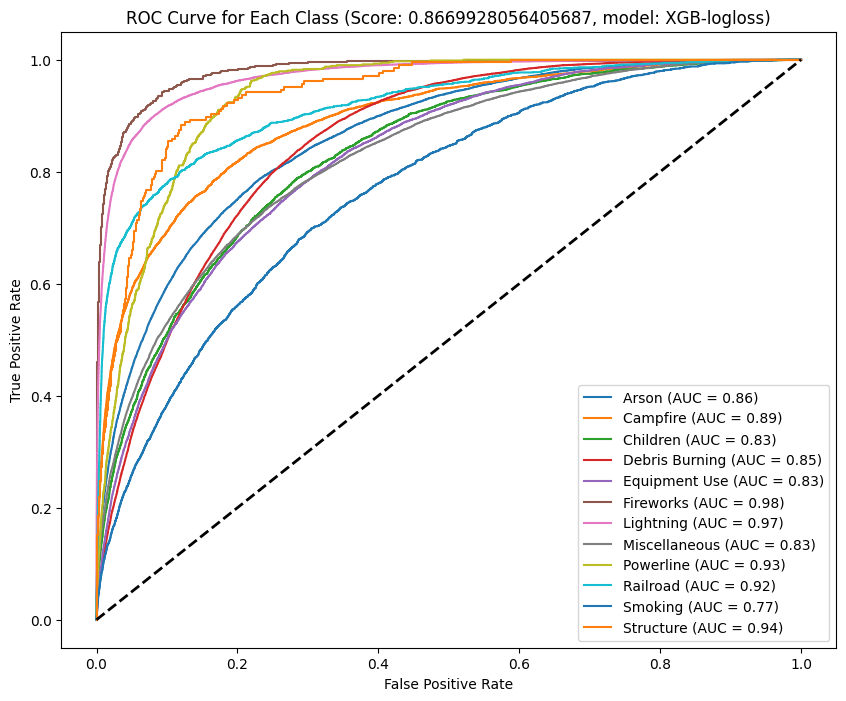

In [94]:
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss')

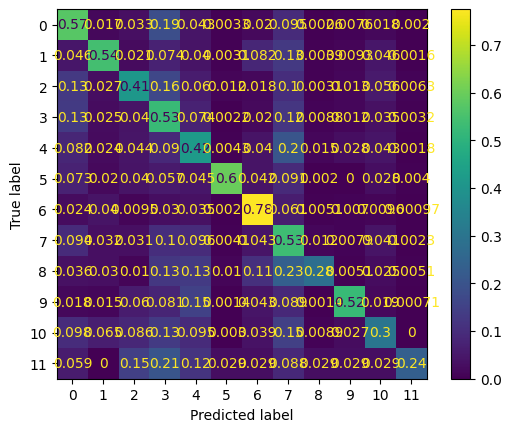

In [95]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

## XGBoost - Balanced

In [96]:
clf = XGBClassifier()
clf.load_model('tempFiles/xgb-balanced.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8582581562620718

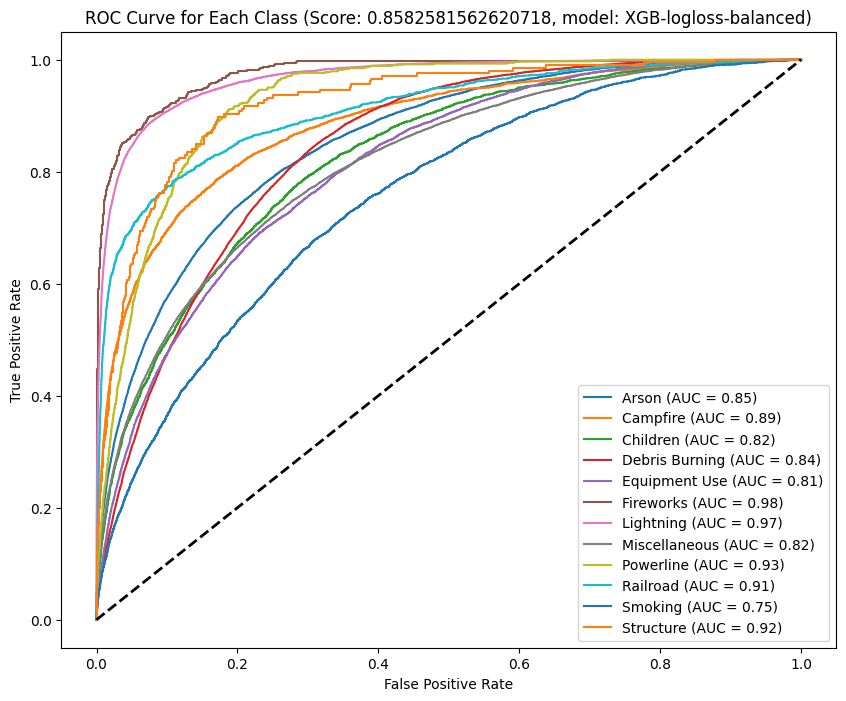

In [97]:
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss-balanced')

## XGBoost - anomaly

In [98]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('tempFiles/xgb-anomaly.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.837124188440938

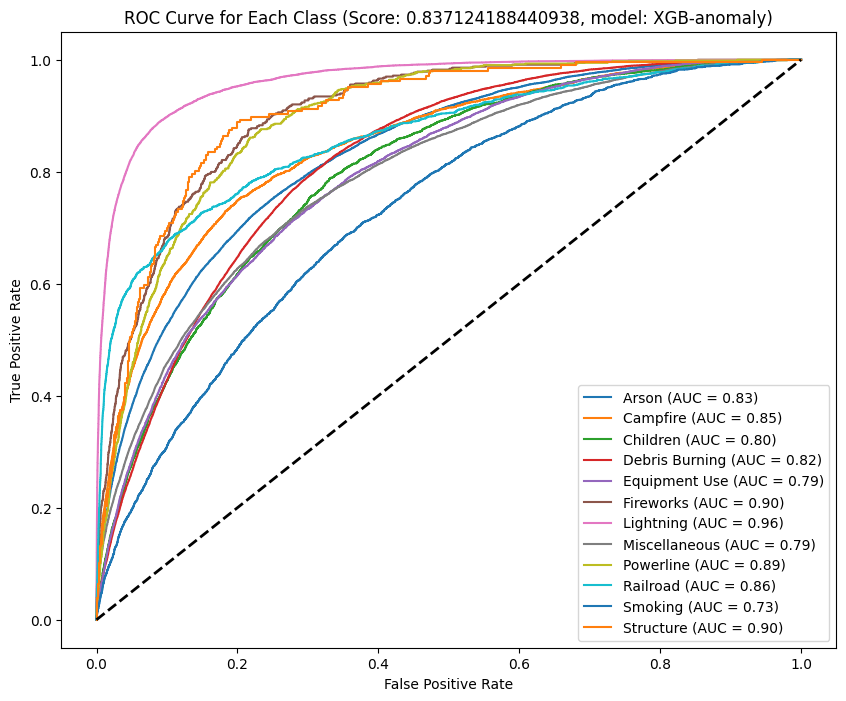

In [99]:
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-anomaly')

## XGBoost feature selection

In [100]:
clf = XGBClassifier()
clf.load_model('tempFiles/xgb-feature.json')

X_train = load_file('tempFiles/X_train_feature.csv')
X_val= load_file('tempFiles/X_val_feature.csv')

y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8490728369230268

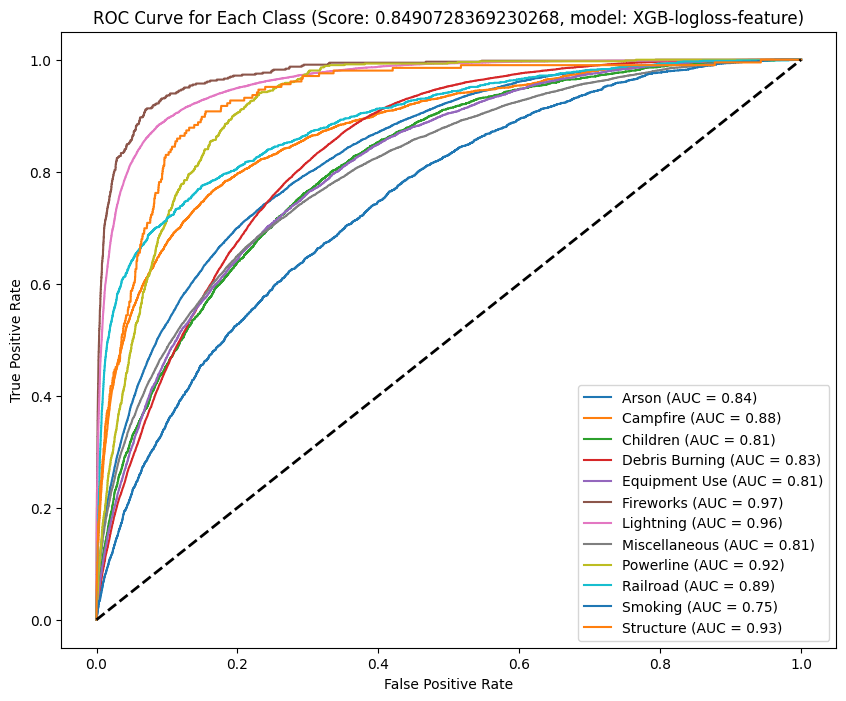

In [101]:
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss-feature')

## CatBoost

In [102]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('tempFiles/X_train_other_model.csv')
y_train = load_file('tempFiles/y_train_other_model.csv')
X_val = load_file('tempFiles/X_val_other_model.csv')
y_val = load_file('tempFiles/y_val_other_model.csv')

In [103]:
!pip install catboost

In [104]:
from catboost import CatBoostClassifier

# Load the CatBoost model from a file
clf = CatBoostClassifier()
clf.load_model('tempFiles/catboost.json')

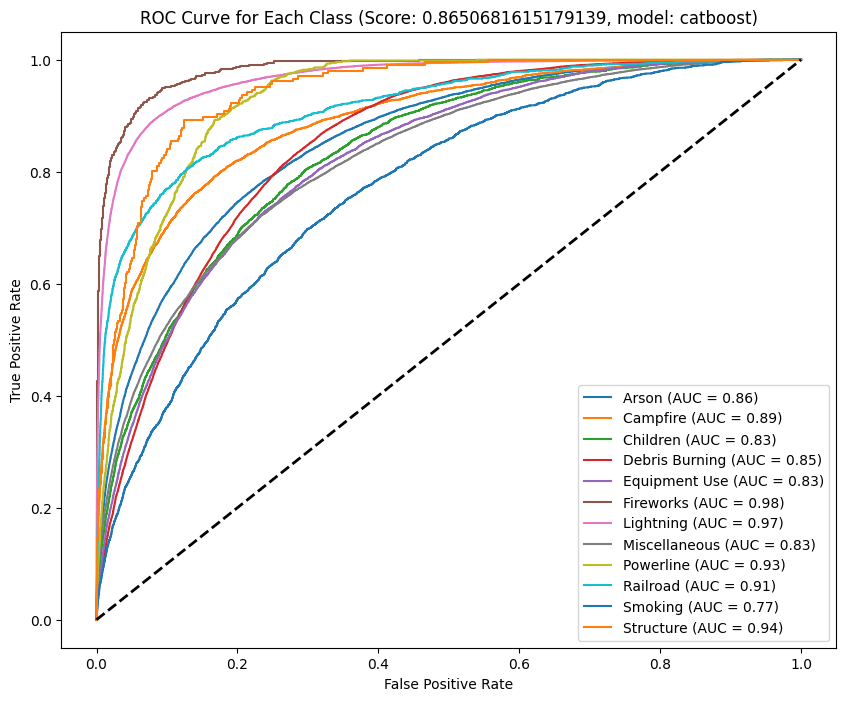

In [105]:
from sklearn.metrics import roc_auc_score

y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'catboost')

## Decision Tree

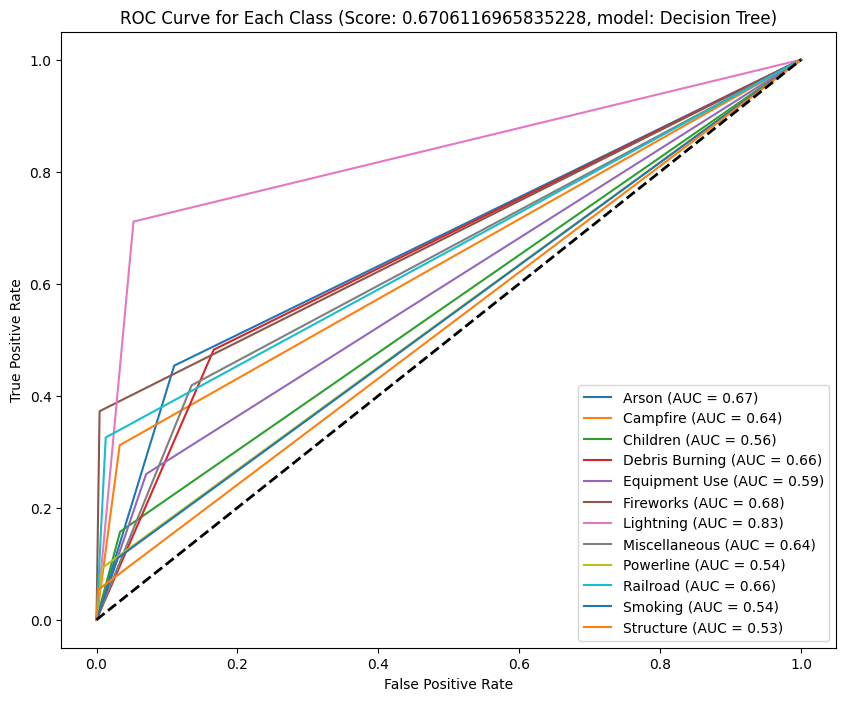

In [106]:
import joblib

# Load the model from a file
clf = joblib.load('tempFiles/decisionTree.json')
from sklearn.metrics import roc_auc_score
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'Decision Tree')

# Final evaluation

Lastly, we will test the best model on our untouched test data:

In [107]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('tempFiles/xgb.json')

y_pred_prob = clf.predict_proba(X_test)  # proba of positive samples
ovr_auc = roc_auc_score(y_test, y_pred_prob, multi_class='ovr',average="weighted")
ovr_auc

0.8666889508294919

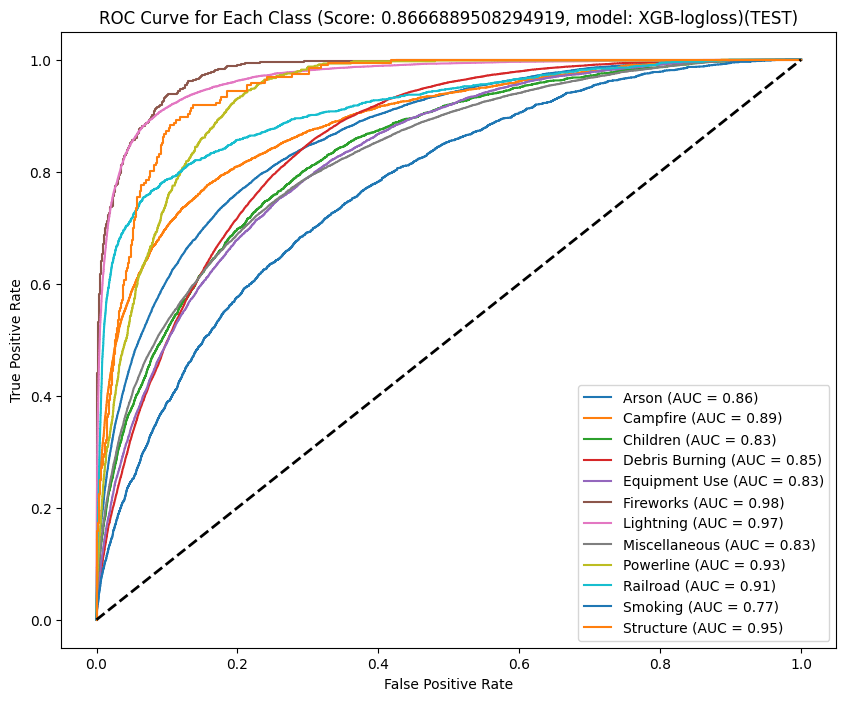

In [108]:
plot_auc_by_class(y_test, y_pred_prob, ovr_auc, 'XGB-logloss)(TEST')